In [2]:
!pip install pandas matplotlib tensorboard numpy sympy scikit-learn ordered-set -q

# Base Configuration

In [3]:
import torch
from pathlib import Path

BASE = Path('EX3')
BASE_DIR_SAMPLES = Path('EX3/samples')

BASE_DIR_DATA = BASE / 'data'
MODELS = BASE / 'models'
PREDITIONS = BASE / 'predictions'

############# TASK 1 ################
DATA_1 = BASE_DIR_DATA / '1'
BASE_DIR_SAMPLES = DATA_1 / 'samples'
TRAIN_1 = DATA_1 / 'train.csv'
TEST_1 = DATA_1 / 'test.csv'
PREDS_1 = PREDITIONS / 'part1'

############# TASK 2 ################
DATA_2 = BASE_DIR_DATA / '2'
TRAIN_2 = DATA_2 / 'train.csv'
TEST_2 = DATA_2 / 'test.csv'
PREDS_2 = PREDITIONS / 'part2'

############# TASK 3 - A ################
DATA_3 = BASE_DIR_DATA / '3'
NER_DIR_DATA = DATA_3 / 'ner'
POS_DIR_DATA = DATA_3 / 'pos'

NER_TRAIN_3 = NER_DIR_DATA / 'train'
NER_TEST_3 = NER_DIR_DATA / 'test'
NER_DEV_3 = NER_DIR_DATA / 'dev'

POS_TRAIN_3 = POS_DIR_DATA / 'train'
POS_TEST_3 = POS_DIR_DATA / 'test'
POS_DEV_3 = POS_DIR_DATA / 'dev'

PREDS_3_A = PREDITIONS / 'part3_A'
MODEL_3_A = MODELS / 'part3_A'
DATASETS_3_A = MODELS / 'part3_A'
DATASETS_3_A_DATA = DATASETS_3_A / 'TokenTagger_instance.pkl'

############# TASK 3 - B ################
DATASETS_3_B = MODELS / 'part3_B'
DATASETS_3_B_DATA = DATASETS_3_B / 'CharLevel_instance.pkl'

############# TASK 3 - C ################
DATASETS_3_C = MODELS / 'part3_C'
DATASETS_3_C_DATA_WORDS = DATASETS_3_C / 'TokenTagger_instance.pkl'
DATASETS_3_C_DATA_SUBWORDS = DATASETS_3_C / 'Subwords_instance.pkl'

EXTERNAL_EMBEDDING = DATA_3 / 'embedding' / 'embedding.txt'
EXTERNAL_VOCAB = DATA_3 / 'embedding' / 'vocab.txt'

############# TASK 3 - D ################
DATASETS_3_D = MODELS / 'part3_D'
DATASETS_3_D_DATA_WORDS = DATASETS_3_D / 'TokenTagger_instance.pkl'
DATASETS_3_D_DATA_CHARS = DATASETS_3_D / 'CharLevel_instance.pkl'

# Create directories if they don't exist
paths = [
    BASE_DIR_DATA,
    MODELS,
    PREDITIONS,
    DATA_1,
    BASE_DIR_SAMPLES,
    DATA_2,
    DATA_3,
    NER_DIR_DATA,
    POS_DIR_DATA,
    PREDS_1,
    PREDS_2,
    PREDS_3_A,
    MODEL_3_A,
    DATASETS_3_A,
    DATASETS_3_B,
    DATASETS_3_C,
    DATASETS_3_D
]

for path in paths:
    path.mkdir(parents=True, exist_ok=True)


MAX_SEQ_LEN = 10
NUM_EXAMPLES = 1000
NUM_SAMPLES_SUBMIT = 500
EMBEDDING_DIM = 50
WINDOW_SIZE = 5
BATCH_SIZE = 128
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Generating the Data

In [39]:
#@title gen examples.py
import os
import random
import csv
def generate_example(is_positive, max_seq_len=MAX_SEQ_LEN, num_examples=NUM_EXAMPLES):
    examples = []
    for _ in range(num_examples):
        seq_len = random.randint(1, max_seq_len)
        sequence_1 = ''.join(str(random.randint(1, 9)) for _ in range(random.randint(1, max_seq_len)))
        sequence_2 = ''.join(str(random.randint(1, 9)) for _ in range(random.randint(1, max_seq_len)))
        sequence_3 = ''.join(str(random.randint(1, 9)) for _ in range(random.randint(1, max_seq_len)))
        sequence_4 = ''.join(str(random.randint(1, 9)) for _ in range(random.randint(1, max_seq_len)))
        sequence_5 = ''.join(str(random.randint(1, 9)) for _ in range(random.randint(1, max_seq_len)))

        if is_positive:
            examples.append(sequence_1 + 'a'*random.randint(1, max_seq_len) + sequence_2 + 'b'*random.randint(1, max_seq_len) + sequence_3 + 'c'*random.randint(1, max_seq_len) + sequence_4 + 'd'*random.randint(1, max_seq_len) + sequence_5)
        else:
            examples.append(sequence_1 + 'a'*random.randint(1, max_seq_len) + sequence_2 + 'c'*random.randint(1, max_seq_len) + sequence_3 + 'b'*random.randint(1, max_seq_len) + sequence_4 + 'd'*random.randint(1, max_seq_len) + sequence_5)
    return examples


def generate_samples(path=BASE_DIR_SAMPLES, num_examples=500, max_seq_len=10):
    pos_examples = [generate_example(True, max_seq_len) for _ in range(num_examples)]
    neg_examples = [generate_example(False, max_seq_len) for _ in range(num_examples)]
    
    # Writing examples to files
    with open(os.path.join(path, 'pos_examples.txt'), 'w') as f:
        for example in pos_examples:
            f.write("%s\n" % example)
        
    with open(os.path.join(path, 'neg_examples.txt'), 'w') as f:
        for example in neg_examples:
            f.write("%s\n" % example)


def generate_dataset(path=BASE_DIR_DATA, max_seq_len=MAX_SEQ_LEN, num_examples=NUM_EXAMPLES):
    pos_examples = [(example, 'POSITIVE') for example in generate_example(True, max_seq_len, num_examples)]
    neg_examples = [(example, 'NEGATIVE') for example in generate_example(False, max_seq_len, num_examples)]
    
    # Shuffling examples
    random.shuffle(pos_examples)
    random.shuffle(neg_examples)
    
    # Combining pos and neg examples
    examples = pos_examples + neg_examples
    random.shuffle(examples)
    
    # Splitting into train and test sets (80-20 split)
    split_index = int(0.8 * len(examples))
    
    train = examples[:split_index]
    test = examples[split_index:]
    
    # Writing examples to CSV files
    with open(os.path.join(DATA_1, 'train.csv'), mode='w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(["Example", "Label"])
        for example in train:
            writer.writerow(example)

    with open(os.path.join(DATA_1, 'test.csv'), mode='w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(["Example", "Label"])
        for example in test:
            writer.writerow(example)

generate_samples()
generate_dataset()

# Writing the RNN acceptor network

In [40]:
#@title experiment.py
import torch
from torch import nn
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from collections import defaultdict
import os
import torch
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from time import time
import matplotlib.pyplot as plt
from typing import List, Tuple
import pandas as pd
import re
import torch.nn.functional as F


import torch
from torch.utils.data import Dataset

class BaseDatabase():
    """
    Abstract class representing a Custom Database
    """
    def __init__(self, padding_token: str = "<PAD>", unknown_token: str = "<UNK>", vocab = []):
        self.padding_token = padding_token
        self.unknown_token = unknown_token
        self.w2i = defaultdict(lambda: self.w2i[unknown_token])  # Word to index
        self.i2w = {}  # Index to word
        self.l2i = defaultdict(int)  # Label to index
        self.i2l = {}  # Index to label
        self.max_seq_len = 0  # Max sequence length
        self.vocab = vocab  # Vocabulary

    def load_data(self) -> Tuple[List[str], List[str]]:
        """
        Abstract method to load data and labels
        """
        raise NotImplementedError("Please implement this method to load data and labels.")

    def build_vocab(self):
        """
        Abstract method to build vocabulary
        """
        raise NotImplementedError("Please implement this method to build vocabulary.")
        
    def build_mappings(self):
        """
        Abstract method to build mappings
        """
        raise NotImplementedError("Please implement this method to build mappings.")

    def word_to_index(self, word: str) -> int:
        """
        Abstract method to transform word to index
        """
        raise NotImplementedError("Please implement this method to transform word to index.")
        
    def label_to_index(self, label: str) -> int:
        """
        Abstract method to transform label to index
        """
        raise NotImplementedError("Please implement this method to transform label to index.")

    def vocab_size(self):
        return len(self.vocab)

    def labels_size(self):
        return len(self.labels)
        
class LanguageClassificationDataset(BaseDatabase):
    """
    A class used to load and preprocess Language Classification Dataset
    """
    def __init__(self, filepath: str, vocab=['a', 'b', 'c', 'd'] + [str(i) for i in range(1, 10)], padding_token: str = "<PAD>", unknown_token: str = "<UNK>", MAX_SEQ_LEN=MAX_SEQ_LEN):
        self.vocab = [padding_token, unknown_token] + vocab
        self.labels = ['POSITIVE', 'NEGATIVE']  # binary labels
        self.filepath = filepath
        self.MAX_SEQ_LEN = MAX_SEQ_LEN 
        super().__init__(padding_token, unknown_token, vocab=self.vocab)
        self.build_vocab()
        self.build_mappings()

    def pad_sequence(self, sequence: str) -> List[int]:
        """
        Pads a sequence to the length of 9 * MAX_SEQ_LEN
        """
        words = [word for word in sequence]
        if len(words) > self.MAX_SEQ_LEN:
            raise ValueError("Sequence length is greater than 9 * MAX_SEQ_LEN")
        
        # Pad the sequence with the padding token
        words += [self.padding_token] * (self.MAX_SEQ_LEN - len(words))
        # Convert words to indices
        return [self.word_to_index(word) for word in words]

    def load_data(self, path) -> Tuple[List[List[str]], List[str]]:
        """
        Loads data and labels from a CSV file, and pads the data sequences
        """
        try:
            df = pd.read_csv(path)
            df.dropna(inplace=True)
            df['Example'] = df['Example'].astype(str)
            df['Label'] = df['Label'].astype(str)
            self.MAX_SEQ_LEN = max([len(seq) for seq in df['Example'].values])
            X = [self.pad_sequence(seq) for seq in df['Example'].values]
            y = [self.label_to_index(label) for label in df['Label'].values]
            
            print(f"Loaded {path} Successfully.")
            return (X, y)
            
        except Exception as e:
            print(f"Error loading data: {e}")
            return [], []

    def build_vocab(self):
        """
        Builds vocabulary based on the given vocab list
        """
        self.w2i = {word: index for index, word in enumerate(self.vocab)}
        self.i2w = {index: word for word, index in self.w2i.items()}

    def build_mappings(self):
        """
        Builds label mappings based on the given labels list
        """
        self.l2i = {label: index for index, label in enumerate(self.labels)}
        self.i2l = {index: label for label, index in self.l2i.items()}

    def word_to_index(self, word: str) -> int:
        """
        Transforms a word to its corresponding index. If the word is not in the vocabulary, 
        it returns the index of the unknown token
        """
        return self.w2i[word]

    def label_to_index(self, label: str) -> int:
        """
        Transforms a label to its corresponding index. If the label is not in the labels list, 
        it raises a ValueError
        """
        if label not in self.l2i:
            raise ValueError(f"Label {label} not found in labels list")
        return self.l2i[label]
        
    def create_pytorch_dataset(self, path: str) -> Dataset:
        X_data, y_data = self.load_data(path)
        return self.CustomDataset(X_data, y_data)

    class CustomDataset(Dataset):
        def __init__(self, X_data, y_data):
            self.X_data = X_data
            self.y_data = y_data
        
        def __len__(self):
            return len(self.X_data)
        
        def __getitem__(self, index):
            return torch.tensor(self.X_data[index], dtype=torch.long), torch.tensor(self.y_data[index], dtype=torch.long)

def create_dataLoader(dataset, batch_size=32, shuffle=True):
    def collate_fn(batch):
        inputs, labels = zip(*batch)
        inputs = torch.stack(inputs).to(device)
        labels = torch.tensor(labels, dtype=torch.long).to(device)
        return inputs, labels

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, collate_fn=collate_fn)
    return dataloader


class LSTMAcceptor(nn.Module):
    def __init__(self, vocab_size: int, embedding_dim: int, lstm_dim: int, hidden_dim: int, output_dim: int, n_layers: int, 
                 dropout: float, pad_idx: int):
        super(LSTMAcceptor, self).__init__()

        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)

        # LSTM layer
        self.lstm = nn.LSTM(embedding_dim, lstm_dim, num_layers=n_layers, batch_first=True)

        # Hidden layer
        self.fc1 = nn.Linear(lstm_dim, hidden_dim)

        # Output layer
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, text):
        # text = [batch size, sent len]
        text_lengths = torch.sum(text != self.embedding.padding_idx, dim=1)
        
        # Pass text through embedding layer
        embedded = self.embedding(text)

        # Pack sequence before passing to the LSTM
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.cpu(), batch_first=True, enforce_sorted=False)
        
        # Pass packed sequence into LSTM
        packed_output, (hidden, _) = self.lstm(packed_embedded)
        
        # Unpack sequence
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)

        # Get the last output for each sequence
        output = output[torch.arange(output.size(0)), output_lengths-1, :]

        # Pass output through the first fully connected layer and apply Tanh activation
        dense_outputs = torch.tanh(self.fc1(output))

        # Pass the results through the output layer
        output = self.fc2(dense_outputs)
        return output


class Runner:
    def __init__(self, train_dataset_path=TRAIN_1, test_dataset_path=TEST_1, base_dir=PREDS_1, vocab=['a', 'b', 'c', 'd'] + [str(i) for i in range(1, 10)], batch_size=16, learning_rate=0.001, embedding_dim=20, lstm_dim=32, hidden_dim=16, output_dim=2, n_layers=1, dropout=0):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.train_dataset_path = train_dataset_path
        self.test_dataset_path = test_dataset_path
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.dataset = LanguageClassificationDataset(train_dataset_path, vocab=vocab)
        self.train_set = self.dataset.create_pytorch_dataset(train_dataset_path)
        self.test_set = self.dataset.create_pytorch_dataset(test_dataset_path)
        
        self.model = LSTMAcceptor(self.dataset.vocab_size(), embedding_dim, lstm_dim, hidden_dim, output_dim, n_layers, dropout, pad_idx=self.dataset.word_to_index('<PAD>')).to(device)
        self.optimizer = Adam(self.model.parameters(), lr=learning_rate, weight_decay=1e-5)\
        
        self.img_dir = os.path.join(base_dir, "imgs")
        os.makedirs(self.img_dir, exist_ok=True)

    def train(self, num_epochs):
        self.train_loader = create_dataLoader(self.train_set, batch_size=self.batch_size, shuffle=True)
        self.train_accs = []
        self.train_losses = []

        start_time = time()
        for epoch in range(num_epochs):
            running_loss = 0.0
            correct = 0
            total = 0
            self.model.train()
            for batch in self.train_loader:
                inputs, labels = batch
                self.optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = F.cross_entropy(outputs, labels)
                loss.backward()
                self.optimizer.step()
                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
            train_acc = correct / total
            train_loss = running_loss / len(self.train_loader)
            self.train_accs.append(train_acc)
            self.train_losses.append(train_loss)

            print(f'Epoch {epoch + 1}/{num_epochs}: Train acc = {train_acc:.4f}, Train loss = {train_loss:.4f}')
        end_time = time()
        print(f'Training completed in {end_time - start_time} seconds.')
        print(f'Number of iterations: {num_epochs * len(self.train_loader)}')

    def evaluate(self):
        self.test_loader = create_dataLoader(self.train_set, batch_size=self.batch_size, shuffle=True)
        self.model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in self.test_loader:
                outputs = self.model(inputs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
        self.test_accuracy = 100 * correct / total
        print(f'Accuracy on test set: {self.test_accuracy}%')

    def plot(self):
        plt.figure(figsize=(10, 5))

        plt.subplot(1, 2, 1)
        plt.plot(self.train_losses, label='Train Loss')
        plt.title('Loss during training')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(self.train_accs, label='Train Accuracy')
        plt.title('Accuracy during training')
        plt.legend()

        plt.savefig(os.path.join(self.img_dir, "training_plot.png"))
        plt.show()

    def run(self, num_epoch=10):
        self.train(num_epoch)
        self.evaluate()
        self.plot()


Loaded EX3/data/1/train.csv Successfully.
Loaded EX3/data/1/test.csv Successfully.
Epoch 1/10: Train acc = 0.5138, Train loss = 0.6923
Epoch 2/10: Train acc = 0.8850, Train loss = 0.3619
Epoch 3/10: Train acc = 0.9587, Train loss = 0.1599
Epoch 4/10: Train acc = 0.9819, Train loss = 0.0806
Epoch 5/10: Train acc = 0.9919, Train loss = 0.0393
Epoch 6/10: Train acc = 0.9975, Train loss = 0.0195
Epoch 7/10: Train acc = 0.9988, Train loss = 0.0088
Epoch 8/10: Train acc = 0.9981, Train loss = 0.0135
Epoch 9/10: Train acc = 1.0000, Train loss = 0.0023
Epoch 10/10: Train acc = 1.0000, Train loss = 0.0016
Training completed in 5.473599433898926 seconds.
Number of iterations: 1000
Accuracy on test set: 100.0%


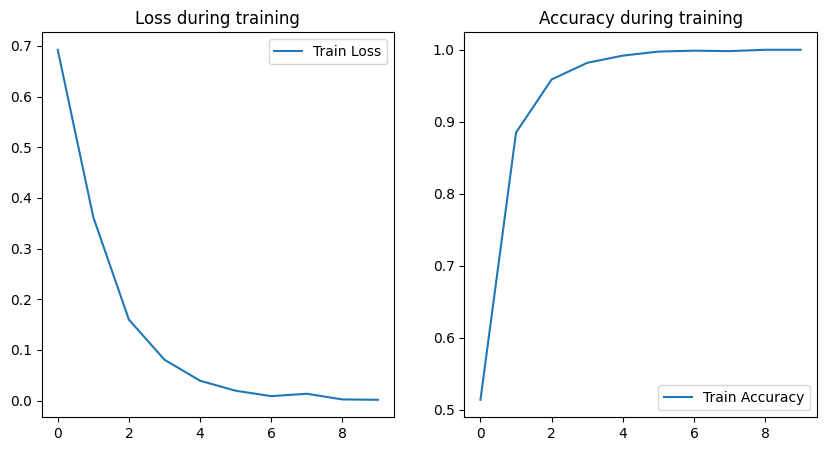

In [41]:
experiment1 = Runner()
experiment1.run()

# Part 2

In [42]:
#@title part2.py
import sympy
import random

def generate_prime_unary(lower, upper):
    prime = sympy.randprime(lower, upper)
    return '1' * prime

def generate_nonprime_unary(lower, upper):
    while True:
        number = random.randint(lower, upper)
        if not sympy.isprime(number):
            return '1' * number


def generate_dataset(path=DATA_2, num_examples=NUM_EXAMPLES):
    pos_examples = [(str(example), 'POSITIVE') for example in [generate_prime_unary(0, 1000) for _ in range(num_examples)]]
    neg_examples = [(str(example), 'NEGATIVE') for example in [generate_nonprime_unary(0, 1000) for _ in range(num_examples)]]
    
    # Shuffling examples
    random.shuffle(pos_examples)
    random.shuffle(neg_examples)
    
    # Combining pos and neg examples
    examples = pos_examples + neg_examples
    random.shuffle(examples)
    
    # Splitting into train and test sets (80-20 split)
    split_index = int(0.8 * len(examples))
    
    train = examples[:split_index]
    test = examples[split_index:]
    
    # Writing examples to CSV files
    with open(os.path.join(path, 'train.csv'), mode='w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(["Example", "Label"])
        for example in train:
            writer.writerow(example)

    with open(os.path.join(path, 'test.csv'), mode='w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(["Example", "Label"])
        for example in test:
            writer.writerow(example)

generate_dataset()

Loaded EX3/data/2/train.csv Successfully.
Loaded EX3/data/2/test.csv Successfully.
Epoch 1/300: Train acc = 0.5078, Train loss = 0.6953
Epoch 2/300: Train acc = 0.4934, Train loss = 0.6942
Epoch 3/300: Train acc = 0.5009, Train loss = 0.6934
Epoch 4/300: Train acc = 0.4897, Train loss = 0.6938
Epoch 5/300: Train acc = 0.5072, Train loss = 0.6934
Epoch 6/300: Train acc = 0.5072, Train loss = 0.6933
Epoch 7/300: Train acc = 0.5041, Train loss = 0.6948
Epoch 8/300: Train acc = 0.5097, Train loss = 0.6933
Epoch 9/300: Train acc = 0.5072, Train loss = 0.6932
Epoch 10/300: Train acc = 0.5072, Train loss = 0.6933
Epoch 11/300: Train acc = 0.5072, Train loss = 0.6931
Epoch 12/300: Train acc = 0.5072, Train loss = 0.6932
Epoch 13/300: Train acc = 0.5072, Train loss = 0.6935
Epoch 14/300: Train acc = 0.4797, Train loss = 0.6936
Epoch 15/300: Train acc = 0.5072, Train loss = 0.6933
Epoch 16/300: Train acc = 0.4947, Train loss = 0.6934
Epoch 17/300: Train acc = 0.5072, Train loss = 0.6935
Epoch 18

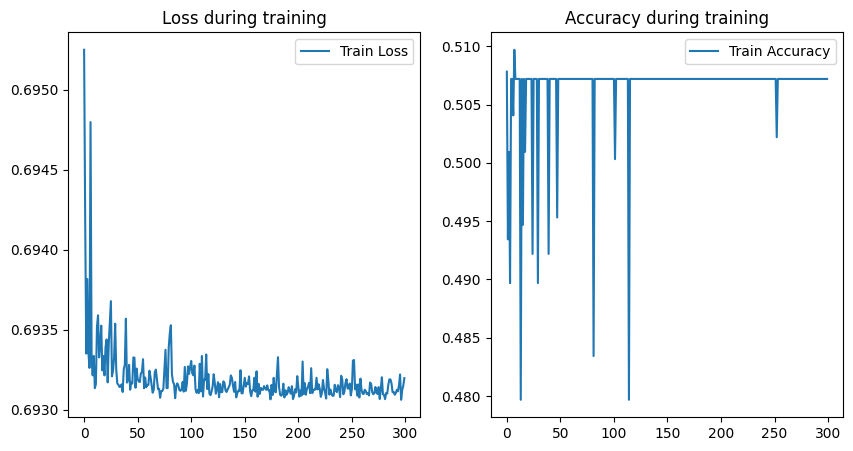

In [43]:
experiment1 = Runner(train_dataset_path=TRAIN_2, test_dataset_path=TEST_2, base_dir=PREDS_2, vocab=['1'], batch_size=32, learning_rate=0.001, embedding_dim=10, lstm_dim=64, hidden_dim=32, output_dim=2, n_layers=1, dropout=0)
experiment1.run(300)

# Part 3

## Utilities

### Download POS/NER/Embedding Data

In [5]:
#@title Download Data:

import os
import tarfile
import urllib.request

def download_POS_data(url='https://u.cs.biu.ac.il/~89-687/ass2/pos.tgz', target_folder=DATA_3):
    # Create target folder if it doesn't exist
    if not os.path.exists(target_folder):
        os.makedirs(target_folder)

    # Download the file
    file_name = os.path.join(target_folder, 'pos.tgz')
    urllib.request.urlretrieve(url, file_name)

    # Extract the file
    with tarfile.open(file_name, 'r:gz') as tar:
        tar.extractall(target_folder)

    # Return the path to the extracted folder
    extracted_folder = os.path.join(target_folder, 'pos')
    return extracted_folder

def download_NER_data(url='https://u.cs.biu.ac.il/~89-687/ass2/ner.tgz', target_folder=DATA_3):
    # Create target folder if it doesn't exist
    if not os.path.exists(target_folder):
        os.makedirs(target_folder)

    # Download the file
    file_name = os.path.join(target_folder, 'ner.tgz')
    urllib.request.urlretrieve(url, file_name)

    # Extract the file
    with tarfile.open(file_name, 'r:gz') as tar:
        tar.extractall(target_folder)

    # Return the path to the extracted folder
    extracted_folder = os.path.join(target_folder, 'ner')
    return extracted_folder


def download_wordembedding(url_embedding='https://u.cs.biu.ac.il/~89-687/ass2/wordVectors.txt', url_vocab='https://u.cs.biu.ac.il/~89-687/ass2/vocab.txt', target_folder=DATA_3):
    # Create target folder if it doesn't exist
    if not os.path.exists(target_folder):
        os.makedirs(target_folder)

    # Create embedding folder if it doesn't exist
    embedding_folder = os.path.join(target_folder, 'embedding')
    if not os.path.exists(embedding_folder):
        os.makedirs(embedding_folder)

    # Download the embedding file
    file_name_embedding = os.path.join(embedding_folder, 'embedding.txt')
    urllib.request.urlretrieve(url_embedding, file_name_embedding)

    # Download the vocab file
    file_name_vocab = os.path.join(embedding_folder, 'vocab.txt')
    urllib.request.urlretrieve(url_vocab, file_name_vocab)

    # Return the path to the embedding folder
    return embedding_folder


pos_data_path = download_POS_data()
ner_data_path = download_NER_data()
embedding_data_path = download_wordembedding()

### Datasets Wrappers

In [6]:
#@title experiment.py
import torch
from torch import nn
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from collections import defaultdict
import os
import torch
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from time import time
import matplotlib.pyplot as plt
from typing import List, Tuple
import pandas as pd
import re
import torch.nn.functional as F


import torch
from torch.utils.data import Dataset

class BaseDatabase():
    """
    Abstract class representing a Custom Database
    """
    def __init__(self, padding_token: str = "<PAD>", unknown_token: str = "<UNK>", vocab = []):
        self.padding_token = padding_token
        self.unknown_token = unknown_token
        self.w2i = defaultdict(lambda: self.w2i[unknown_token])  # Word to index
        self.i2w = {}  # Index to word
        self.l2i = defaultdict(int)  # Label to index
        self.i2l = {}  # Index to label
        self.max_seq_len = 0  # Max sequence length
        self.vocab = vocab  # Vocabulary

    def load_data(self) -> Tuple[List[str], List[str]]:
        """
        Abstract method to load data and labels
        """
        raise NotImplementedError("Please implement this method to load data and labels.")

    def build_vocab(self):
        """
        Abstract method to build vocabulary
        """
        raise NotImplementedError("Please implement this method to build vocabulary.")
        
    def build_mappings(self):
        """
        Abstract method to build mappings
        """
        raise NotImplementedError("Please implement this method to build mappings.")

    def word_to_index(self, word: str) -> int:
        """
        Abstract method to transform word to index
        """
        raise NotImplementedError("Please implement this method to transform word to index.")
        
    def label_to_index(self, label: str) -> int:
        """
        Abstract method to transform label to index
        """
        raise NotImplementedError("Please implement this method to transform label to index.")

    def vocab_size(self):
        return len(self.vocab)

    def labels_size(self):
        return len(self.labels)
        
class LanguageClassificationDataset(BaseDatabase):
    """
    A class used to load and preprocess Language Classification Dataset
    """
    def __init__(self, filepath: str, vocab=['a', 'b', 'c', 'd'] + [str(i) for i in range(1, 10)], padding_token: str = "<PAD>", unknown_token: str = "<UNK>", MAX_SEQ_LEN=MAX_SEQ_LEN):
        self.vocab = [padding_token, unknown_token] + vocab
        self.labels = ['POSITIVE', 'NEGATIVE']  # binary labels
        self.filepath = filepath
        self.MAX_SEQ_LEN = MAX_SEQ_LEN 
        super().__init__(padding_token, unknown_token, vocab=self.vocab)
        self.build_vocab()
        self.build_mappings()

    def pad_sequence(self, sequence: str) -> List[int]:
        """
        Pads a sequence to the length of 9 * MAX_SEQ_LEN
        """
        words = [word for word in sequence]
        if len(words) > self.MAX_SEQ_LEN:
            raise ValueError("Sequence length is greater than 9 * MAX_SEQ_LEN")
        
        # Pad the sequence with the padding token
        words += [self.padding_token] * (self.MAX_SEQ_LEN - len(words))
        # Convert words to indices
        return [self.word_to_index(word) for word in words]

    def load_data(self, path) -> Tuple[List[List[str]], List[str]]:
        """
        Loads data and labels from a CSV file, and pads the data sequences
        """
        try:
            df = pd.read_csv(path)
            df.dropna(inplace=True)
            df['Example'] = df['Example'].astype(str)
            df['Label'] = df['Label'].astype(str)
            self.MAX_SEQ_LEN = max([len(seq) for seq in df['Example'].values])
            X = [self.pad_sequence(seq) for seq in df['Example'].values]
            y = [self.label_to_index(label) for label in df['Label'].values]
            
            print(f"Loaded {path} Successfully.")
            return (X, y)
            
        except Exception as e:
            print(f"Error loading data: {e}")
            return [], []

    def build_vocab(self):
        """
        Builds vocabulary based on the given vocab list
        """
        self.w2i = {word: index for index, word in enumerate(self.vocab)}
        self.i2w = {index: word for word, index in self.w2i.items()}

    def build_mappings(self):
        """
        Builds label mappings based on the given labels list
        """
        self.l2i = {label: index for index, label in enumerate(self.labels)}
        self.i2l = {index: label for label, index in self.l2i.items()}

    def word_to_index(self, word: str) -> int:
        """
        Transforms a word to its corresponding index. If the word is not in the vocabulary, 
        it returns the index of the unknown token
        """
        return self.w2i[word]

    def label_to_index(self, label: str) -> int:
        """
        Transforms a label to its corresponding index. If the label is not in the labels list, 
        it raises a ValueError
        """
        if label not in self.l2i:
            raise ValueError(f"Label {label} not found in labels list")
        return self.l2i[label]
        
    def create_pytorch_dataset(self, path: str) -> Dataset:
        X_data, y_data = self.load_data(path)
        return self.CustomDataset(X_data, y_data)

    class CustomDataset(Dataset):
        def __init__(self, X_data, y_data):
            self.X_data = X_data
            self.y_data = y_data
        
        def __len__(self):
            return len(self.X_data)
        
        def __getitem__(self, index):
            return torch.tensor(self.X_data[index], dtype=torch.long), torch.tensor(self.y_data[index], dtype=torch.long)

In [7]:
import re
import copy
from ordered_set import OrderedSet

class TokenTaggingDataset(BaseDatabase):
    """
    A class used to load and preprocess Token Tagging Dataset
    """
    def __init__(
        self,
        filepath: str,
        delimiter: str,
        padding_token: str = "<PAD>",
        unknown_token: str = "<UNK>",
        external: bool = False
    ):
        self.delimiter = delimiter
        self.special_tokens = [padding_token, unknown_token, "<DATE>", "<NUMBER>", "<PUNC>"]
        self.filepath=filepath
        self.max_len = 0
        self.external = external
        super().__init__(padding_token, unknown_token)

    def load_data(self, filepath: str) -> None:
        """
        Loads data and labels from a file, tokenizes them, and builds a vocabulary
        """
        with open(filepath, "r", encoding="utf-8") as file:
            content = file.read().strip()

        raw_sentences = content.split("\n\n")  # sentences are divided by '\n\n'
        sentences, labels = [], []

        for raw_sentence in raw_sentences:
            lines = raw_sentence.split("\n")
            sentence = []
            label = []
            for line in lines:
                split_line = line.strip().split(self.delimiter)
                word = split_line[0]
                if len(split_line) > 1:
                    word_label = split_line[1]
                else:
                    word_label = self.unknown_token  # assign dummy label if none is provided
                sentence.append(word)
                label.append(word_label)
            sentences.append(' '.join(sentence))
            labels.append(' '.join(label))

        if not self.vocab:
          self.build_vocab(sentences, labels)

        X = [self.tokenize_sentence(sentence) for sentence in sentences]
        y = [self.tokenize_labels(label) for label in labels]

        print(f"Data from {filepath} has been loaded successfully.")

        return (X, y)

    def load_external(self, path=EXTERNAL_VOCAB):
        with open(path, 'r') as file:
            vocab_txt = file.read()
            external_vocab = OrderedSet(word.strip() for word in vocab_txt.split('\n') if word.strip())
            
        return external_vocab
        
    def build_vocab(self, sentences: List[str], labels: List[str]) -> None:
        """
        Builds vocabulary based on the words in each sentence and the labels
        """
        vocab = set() if not self.external else self.load_external()
        label_vocab = set()
        self.max_len = max([len(sentence.split()) for sentence in sentences])

        for sentence in sentences:
            words = sentence.split()
            vocab.update(words)
            vocab.update([word.lower() for word in words])

        for label in labels:
            labels = label.split()
            label_vocab.update(labels)

        self.vocab = self.special_tokens + list(vocab)
        self.labels = [self.padding_token, self.unknown_token] + list(label_vocab)

        self.build_mappings()

    def tokenize_sentence(self, sentence: str) -> List[int]:
        """
        Tokenizes a sentence by replacing special tokens and padding it to max_len
        """
        tokens = []
        words = sentence.split()

        for word in words:
            lower_word = word.lower()
            if re.match(r"\d{2}-\d{2}-\d{4}", word):  # DATE regex
                tokens.append(self.w2i["<DATE>"])
            elif re.match(r"\d+", word):  # NUMBER regex
                tokens.append(self.w2i["<NUMBER>"])
            elif re.match(r"\W", word):  # PUNC regex
                tokens.append(self.w2i["<PUNC>"])
            elif word in self.w2i:
                tokens.append(self.w2i[word])
            elif lower_word in self.w2i:
                tokens.append(self.w2i[lower_word])
            else:
                tokens.append(self.w2i[self.unknown_token])

        # Pad the sentence to max_len
        if len(tokens) < self.max_len:
            tokens += [self.w2i[self.padding_token]] * (self.max_len - len(tokens))
        else:
            tokens = tokens[: self.max_len]

        return tokens

    def tokenize_labels(self, label: str) -> List[int]:
        """
        Tokenizes a label by replacing special tokens and padding it to max_len
        """
        tokens = []

        for token in label.split():
            if token in self.l2i:
                tokens.append(self.l2i[token])
            else:
                tokens.append(self.l2i[self.unknown_token])

        # Pad the label to max_len
        if len(tokens) < self.max_len:
            tokens += [self.l2i[self.padding_token]] * (self.max_len - len(tokens))
        else:
            tokens = tokens[: self.max_len]

        return tokens

    def build_mappings(self) -> None:
        """
        Builds word-to-index and label-to-index mappings
        """
        self.w2i = {word: index for index, word in enumerate(self.vocab)}
        self.i2w = {index: word for word, index in self.w2i.items()}
        self.l2i = {label: index for index, label in enumerate(self.labels)}
        self.i2l = {index: label for label, index in self.l2i.items()}

    def word_to_index(self, word: str) -> int:
        """
        Transforms a word to its corresponding index. If the word is not in the vocabulary, 
        it returns the index of the unknown token
        """
        return self.w2i[word]

    def label_to_index(self, label: str) -> int:
        """
        Transforms a label to its corresponding index. If the label is not in the labels list, 
        it raises a ValueError
        """
        if label not in self.l2i:
            raise ValueError(f"Label {label} not found in labels list")
        return self.l2i[label]
        
    def create_pytorch_dataset(self, path: str) -> Dataset:
        class CustomDataset(Dataset):
            def __init__(self, X_data, y_data):
                self.X_data = X_data
                self.y_data = y_data
            
            def __len__(self):
                return len(self.X_data)
            
            def __getitem__(self, index):
                return torch.tensor(self.X_data[index], dtype=torch.long), torch.tensor(self.y_data[index], dtype=torch.long)

        X_data, y_data = self.load_data(path)
        return CustomDataset(X_data, y_data)

In [8]:
import re
import copy

class CharLevel(BaseDatabase):
    """
    A class used to load and preprocess Token Tagging Dataset
    """
    def __init__(
        self,
        filepath: str,
        delimiter: str,
        padding_token: str = "<PAD>",
        unknown_token: str = "<UNK>",
    ):
        self.delimiter = delimiter
        self.special_tokens = [padding_token, unknown_token, "<DATE>", "<NUMBER>", "<PUNC>"]
        self.filepath=filepath
        self.max_len = 0
        super().__init__(padding_token, unknown_token)

    def load_data(self, filepath: str) -> None:
        """
        Loads data and labels from a file, tokenizes them, and builds a vocabulary
        """
        with open(filepath, "r", encoding="utf-8") as file:
            content = file.read().strip()

        raw_sentences = content.split("\n\n")  # sentences are divided by '\n\n'
        sentences, labels = [], []

        for raw_sentence in raw_sentences:
            lines = raw_sentence.split("\n")
            sentence = []
            label = []
            for line in lines:
                split_line = line.strip().split(self.delimiter)
                word = split_line[0]
                if len(split_line) > 1:
                    word_label = split_line[1]
                else:
                    word_label = self.unknown_token  # assign dummy label if none is provided
                sentence.append(word)
                label.append(word_label)
            sentences.append(' '.join(sentence))
            labels.append(' '.join(label))

        if not self.vocab:
          self.build_vocab(sentences, labels)

        X = [self.tokenize_sentence(sentence) for sentence in sentences]
        y = [self.tokenize_labels(label) for label in labels]

        print(f"Data from {filepath} has been loaded successfully.")
        return (X,y)

    def word_to_chars(self, word: str) -> List[str]:
        return [char for char in word]

    def build_vocab(self, sentences: List[str], labels: List[str]) -> None:
        """
        Builds vocabulary based on the words in each sentence and the labels
        """

        vocab = set()
        label_vocab = set()
        self.max_len = max([len(sentence.split()) for sentence in sentences])
        self.max_word_len = max(max(len(word) for word in sentence.split()) for sentence in sentences)

        for sentence in sentences:
            chars = list(sentence)
            vocab.update(chars)
        for label in labels:
            labels = label.split()
            label_vocab.update(labels)

        self.vocab = self.special_tokens + list(vocab)
        self.labels = [self.padding_token, self.unknown_token] + list(label_vocab)

        self.build_mappings()

    def tokenize_sentence(self, sentence: str) -> List[List[int]]:
        """
        Tokenizes a sentence by replacing special tokens and padding it to max_len
        """
        tokens = []
        words = sentence.split()

        for word in words:
            chars = self.word_to_chars(word)
            char_indices = [self.w2i[char] for char in chars if char in self.w2i]

            if len(char_indices) < self.max_word_len:
                char_indices += [self.w2i[self.padding_token]] * (self.max_word_len - len(char_indices))
            else:
                char_indices = char_indices[:self.max_word_len]

            tokens.append(char_indices)
            
        # Pad the sentence to max_len
        if len(tokens) < self.max_len:
            tokens += [[self.w2i[self.padding_token]] * self.max_word_len] * (self.max_len - len(tokens))
        else:
            tokens = tokens[: self.max_len]

        return tokens


    def tokenize_labels(self, label: str) -> List[int]:
        """
        Tokenizes a label by replacing special tokens and padding it to max_len
        """
        tokens = []

        for token in label.split():
            if token in self.l2i:
                tokens.append(self.l2i[token])
            else:
                tokens.append(self.l2i[self.unknown_token])

        # Pad the label to max_len
        if len(tokens) < self.max_len:
            tokens += [self.l2i[self.padding_token]] * (self.max_len - len(tokens))
        else:
            tokens = tokens[: self.max_len]

        return tokens
        
    def build_mappings(self) -> None:
        """
        Builds word-to-index and label-to-index mappings
        """
        self.w2i = {word: index for index, word in enumerate(self.vocab)}
        self.i2w = {index: word for word, index in self.w2i.items()}
        self.l2i = {label: index for index, label in enumerate(self.labels)}
        self.i2l = {index: label for label, index in self.l2i.items()}

    def word_to_index(self, word: str) -> int:
        """
        Transforms a word to its corresponding index. If the word is not in the vocabulary, 
        it returns the index of the unknown token
        """
        return self.w2i[word]

    def label_to_index(self, label: str) -> int:
        """
        Transforms a label to its corresponding index. If the label is not in the labels list, 
        it raises a ValueError
        """
        if label not in self.l2i:
            raise ValueError(f"Label {label} not found in labels list")
        return self.l2i[label]

    def create_pytorch_dataset(self, path: str) -> Dataset:
        class CustomDataset(Dataset):
            def __init__(self, X_data, y_data):
                self.X_data = X_data
                self.y_data = y_data
            
            def __len__(self):
                return len(self.X_data)
            
            def __getitem__(self, index):
                return torch.tensor(self.X_data[index], dtype=torch.long), torch.tensor(self.y_data[index], dtype=torch.long)

        X_data, y_data = self.load_data(path)
        return CustomDataset(X_data, y_data)

In [9]:
import re
import copy

class SubWords(BaseDatabase):
    """
    A class used to load and preprocess Token Tagging Dataset
    """
    def __init__(
        self,
        filepath: str,
        delimiter: str,
        padding_token: str = "<PAD>",
        unknown_token: str = "<UNK>",
    ):
        self.delimiter = delimiter
        self.special_tokens = [padding_token, unknown_token, "<DATE>", "<NUMBER>", "<PUNC>"]
        self.filepath=filepath
        self.max_len = 0
        super().__init__(padding_token, unknown_token)

    def load_data(self, filepath: str) -> None:
        """
        Loads data and labels from a file, tokenizes them, and builds a vocabulary
        """
        with open(filepath, "r", encoding="utf-8") as file:
            content = file.read().strip()

        raw_sentences = content.split("\n\n")  # sentences are divided by '\n\n'
        sentences, labels = [], []

        for raw_sentence in raw_sentences:
            lines = raw_sentence.split("\n")
            sentence = []
            label = []
            for line in lines:
                split_line = line.strip().split(self.delimiter)
                word = split_line[0]
                if len(split_line) > 1:
                    word_label = split_line[1]
                else:
                    word_label = self.unknown_token  # assign dummy label if none is provided
                sentence.append(word)
                label.append(word_label)
            sentences.append(' '.join(sentence))
            labels.append(' '.join(label))

        if not self.vocab:
          self.build_vocab(sentences, labels)

        X = [self.tokenize_sentence(sentence) for sentence in sentences]
        y = [self.tokenize_labels(label) for label in labels]

        print(f"Data from {filepath} has been loaded successfully.")
        return (X,y)

    def word_to_subwords(self, word: str) -> List[str]:
        prefix = word[:3]
        suffix = word[-3:]
        return [prefix, suffix]

    def build_vocab(self, sentences: List[str], labels: List[str]) -> None:
        """
        Builds vocabulary based on the words in each sentence and the labels
        """

        vocab = set()
        label_vocab = set()
        self.max_len = max([len(sentence.split()) for sentence in sentences])

        for sentence in sentences:
            for word in sentence:
                vocab.update(self.word_to_subwords(word))
                vocab.update(self.word_to_subwords(word.lower()))
                
        for label in labels:
            labels = label.split()
            label_vocab.update(labels)

        self.vocab = self.special_tokens + list(vocab)
        self.labels = [self.padding_token, self.unknown_token] + list(label_vocab)

        self.build_mappings()

    def tokenize_sentence(self, sentence: str) -> List[List[int]]:
        """
        Tokenizes a sentence by replacing special tokens and padding it to max_len
        """
        tokens = []
        words = sentence.split()

        for word in words:
            subwords = self.word_to_subwords(word)
            subwords_indices = [self.w2i[subword] if subword in self.w2i.keys() else self.w2i[self.unknown_token] for subword in subwords]
            tokens.append(subwords_indices)
            
        # Pad the sentence to max_len
        if len(tokens) < self.max_len:
            tokens += [[self.w2i[self.padding_token]] * 2] * (self.max_len - len(tokens))
        else:
            tokens = tokens[: self.max_len]

        return tokens


    def tokenize_labels(self, label: str) -> List[int]:
        """
        Tokenizes a label by replacing special tokens and padding it to max_len
        """
        tokens = []

        for token in label.split():
            if token in self.l2i:
                tokens.append(self.l2i[token])
            else:
                tokens.append(self.l2i[self.unknown_token])

        # Pad the label to max_len
        if len(tokens) < self.max_len:
            tokens += [self.l2i[self.padding_token]] * (self.max_len - len(tokens))
        else:
            tokens = tokens[: self.max_len]

        return tokens
        
    def build_mappings(self) -> None:
        """
        Builds word-to-index and label-to-index mappings
        """
        self.w2i = {word: index for index, word in enumerate(self.vocab)}
        self.i2w = {index: word for word, index in self.w2i.items()}
        self.l2i = {label: index for index, label in enumerate(self.labels)}
        self.i2l = {index: label for label, index in self.l2i.items()}

    def word_to_index(self, word: str) -> int:
        """
        Transforms a word to its corresponding index. If the word is not in the vocabulary, 
        it returns the index of the unknown token
        """
        return self.w2i[word]

    def label_to_index(self, label: str) -> int:
        """
        Transforms a label to its corresponding index. If the label is not in the labels list, 
        it raises a ValueError
        """
        if label not in self.l2i:
            raise ValueError(f"Label {label} not found in labels list")
        return self.l2i[label]

    def create_pytorch_dataset(self, path: str) -> Dataset:
        class CustomDataset(Dataset):
            def __init__(self, X_data, y_data):
                self.X_data = X_data
                self.y_data = y_data
            
            def __len__(self):
                return len(self.X_data)
            
            def __getitem__(self, index):
                return torch.tensor(self.X_data[index], dtype=torch.long), torch.tensor(self.y_data[index], dtype=torch.long)

        X_data, y_data = self.load_data(path)
        return CustomDataset(X_data, y_data)

### LSTMs

In [10]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class BiLSTMTransducer(nn.Module):
    def __init__(self, vocab_size: int, embedding_dim: int, lstm_hidden_dim: int, output_dim: int, n_layers: int, 
                 dropout: float, pad_idx: int):
        super(BiLSTMTransducer, self).__init__()

        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.pad_idx = pad_idx

        # BiLSTM layer
        self.bilstm = nn.LSTM(embedding_dim, lstm_hidden_dim, num_layers=n_layers, 
                              dropout=dropout, bidirectional=True, batch_first=True)

        # Output layer
        self.fc = nn.Linear(lstm_hidden_dim*2, output_dim)

    def forward(self, text):
        # text = [batch size, sent len]

        # Pass text through embedding layer
        embedded = self.embedding(text)

        # Compute sequence lengths
        text_lengths = torch.sum(text != self.pad_idx, dim=1)  # change to self.pad_idx
        total_length = text.shape[1]
        
        # Pack padded sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.cpu(), batch_first=True, enforce_sorted=False)

        # Pass embeddings into BiLSTM
        packed_output, _ = self.bilstm(packed_embedded)
        
        # Unpack sequence
        output, _ = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True, total_length=total_length)

        # Pass the outputs through the output layer
        outputs = self.fc(output)
        
        return outputs  # return outputs instead of output



In [11]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import numpy as np
from io import StringIO

class BiLSTMTransducerSubwords(nn.Module):
    def __init__(self, subword_vocab_size: int, word_vocab_size: int, subword_embedding_dim: int, word_embedding_dim: int, subword_lstm_hidden_dim:int, lstm_hidden_dim: int, output_dim: int, n_layers: int, 
                 dropout: float, subword_pad_idx: int, word_pad_idx: int, external=False, special_tokens_size=5):
        super(BiLSTMTransducerSubwords, self).__init__()
                     
        def load_external(path=EXTERNAL_EMBEDDING, added_vocab_size=special_tokens_size):
            with open(path, 'r') as file:
                embeddings_txt = file.read()
                embeddings = np.loadtxt(StringIO(embeddings_txt))
                
                # Add vectors for special tokens at the beginning
                special_embeddings = np.random.normal(size=(added_vocab_size, embeddings.shape[1]))

                # Add vectors for new tokens at the end
                added_embeddings = np.random.normal(size=(word_vocab_size - embeddings.shape[0] - added_vocab_size, embeddings.shape[1]))

                # Combine old embeddings with new ones
                embeddings = np.concatenate([special_embeddings, embeddings, added_embeddings], axis=0)

                embeddings = torch.from_numpy(embeddings).float()  # Convert numpy array to PyTorch tensor
            return nn.Embedding.from_pretrained(embeddings, freeze=False, padding_idx=word_pad_idx)
            
        # Embedding layer
        self.subword_embedding = nn.Embedding(subword_vocab_size, subword_embedding_dim, padding_idx=subword_pad_idx)
        self.word_embedding = nn.Embedding(word_vocab_size, word_embedding_dim, padding_idx=word_pad_idx) if not external else load_external()
        self.subword_pad_idx = subword_pad_idx
        self.word_pad_idx = word_pad_idx
        
        self.lstm_chars = nn.LSTM(subword_embedding_dim, subword_lstm_hidden_dim, num_layers=1, batch_first=True)

        # BiLSTM layer
        self.bilstm = nn.LSTM(subword_embedding_dim + word_embedding_dim, lstm_hidden_dim, num_layers=n_layers, 
                              dropout=dropout, bidirectional=True, batch_first=True)

        # Output layer
        self.fc = nn.Linear(lstm_hidden_dim*2, output_dim)

    def forward_chars(self, text):
         # text = [batch size, sent len, word len]
        batch_size, sent_len, word_len = text.size()
        # Reshape text for embedding
        reshaped_text = text.view(batch_size * sent_len, word_len)

        # Compute lengths for each sequence in reshaped text
        char_lengths = torch.sum((reshaped_text != self.subword_pad_idx), dim=1)
        
        # Filter out the all-padding words
        non_zero_idx = torch.nonzero(char_lengths, as_tuple=True)[0]

        non_zero_lengths = char_lengths[non_zero_idx]
        non_zero_reshaped = reshaped_text[non_zero_idx]
        
        # Pass text through embedding layer
        embedded = self.subword_embedding(non_zero_reshaped)

        # Pack the sequences
        packed_embedded = pack_padded_sequence(embedded, non_zero_lengths.cpu(), batch_first=True, enforce_sorted=False)
        
        packed_output, _ = self.lstm_chars(packed_embedded)
        
        # Pad the sequence to the max length in the batch
        char_output, _ = pad_packed_sequence(packed_output, batch_first=True)

        # Take the last non-padding output for each sequence to create word embeddings
        word_embedding = char_output[torch.arange(char_output.size(0)).to(text.device), non_zero_lengths-1]

        # Create an all-zero tensor to hold the word embeddings including the all-padding words
        all_word_embedding = torch.zeros(batch_size * sent_len, word_embedding.size(-1)).to(word_embedding.device)

        # Place the word embeddings in their corresponding place, leave the all-padding words as zero
        all_word_embedding[non_zero_idx] = word_embedding

        # Reshape back to [batch size, sent len, embedding dim]
        all_word_embedding = all_word_embedding.view(batch_size, sent_len, -1)
        
        return all_word_embedding
        
    def forward(self, sentences_words, sentences_characters):
        # text = [batch size, sent len]
        sentences_characters_vecs = self.forward_chars(sentences_characters)

        # Pass text through embedding layer
        embedded = self.word_embedding(sentences_words)
    
        # Compute sequence lengths
        text_lengths = torch.sum(sentences_words != self.word_pad_idx, dim=1) 
        total_length = sentences_words.shape[1]
        
        # Prepare a placeholder tensor for the concatenated output
        output = torch.zeros(embedded.shape[0], total_length, embedded.shape[2] + sentences_characters_vecs.shape[2]).to(embedded.device)
        
        for i, length in enumerate(text_lengths):
            # Concatenate the non-padding parts
            output[i, :length] = torch.cat((embedded[i, :length], sentences_characters_vecs[i, :length]), dim=-1)
        
        # Pack padded sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(output, text_lengths.cpu(), batch_first=True, enforce_sorted=False)

        # Pass embeddings into BiLSTM
        packed_output, _ = self.bilstm(packed_embedded)
        
        # Unpack sequence
        output, _ = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True, total_length=total_length)
        
        # Pass the outputs through the output layer
        outputs = self.fc(output)
        
        return outputs  # return outputs instead of output

In [12]:
import torch
from torch import nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class LSTMCharLevel(nn.Module):
    def __init__(self, vocab_size: int, embedding_dim: int, char_lstm_hidden_dim: int, 
                 lstm_hidden_dim: int, n_layers: int, output_dim: int, dropout: float, pad_idx: int):
        super(LSTMCharLevel, self).__init__()
        self.pad_idx = pad_idx
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.lstm_chars = nn.LSTM(embedding_dim, char_lstm_hidden_dim, num_layers=1, batch_first=True)
                     
        self.bilstm = nn.LSTM(char_lstm_hidden_dim, lstm_hidden_dim, num_layers=n_layers, 
                              dropout=dropout if n_layers > 1 else 0, bidirectional=True, batch_first=True)

        self.fc = nn.Linear(lstm_hidden_dim*2, output_dim)
        
    def forward(self, text):
        # text = [batch size, sent len, word len]
        batch_size, sent_len, word_len = text.size()
        # Reshape text for embedding
        reshaped_text = text.view(batch_size * sent_len, word_len)

        # Compute lengths for each sequence in reshaped text
        char_lengths = torch.sum((reshaped_text != self.pad_idx), dim=1)
        
        # Filter out the all-padding words
        non_zero_idx = torch.nonzero(char_lengths, as_tuple=True)[0]

        non_zero_lengths = char_lengths[non_zero_idx]
        non_zero_reshaped = reshaped_text[non_zero_idx]
        
        # Pass text through embedding layer
        embedded = self.embedding(non_zero_reshaped)

        # Pack the sequences
        packed_embedded = pack_padded_sequence(embedded, non_zero_lengths.cpu(), batch_first=True, enforce_sorted=False)
        
        packed_output, _ = self.lstm_chars(packed_embedded)
        
        # Pad the sequence to the max length in the batch
        char_output, _ = pad_packed_sequence(packed_output, batch_first=True)

        # Take the last non-padding output for each sequence to create word embeddings
        word_embedding = char_output[torch.arange(char_output.size(0)).to(text.device), non_zero_lengths-1]

        # Create an all-zero tensor to hold the word embeddings including the all-padding words
        all_word_embedding = torch.zeros(batch_size * sent_len, word_embedding.size(-1)).to(word_embedding.device)

        # Place the word embeddings in their corresponding place, leave the all-padding words as zero
        all_word_embedding[non_zero_idx] = word_embedding

        # Reshape back to [batch size, sent len, embedding dim]
        all_word_embedding = all_word_embedding.view(batch_size, sent_len, -1)

        output, _ = self.bilstm(all_word_embedding)

        # Pass the outputs through the output layer
        outputs = self.fc(output)

        return outputs

### Runners

In [26]:
import torch
from torch.optim import Adam, lr_scheduler
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader
import torch.nn.functional as F
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
import pickle

class Runner_A:
    def __init__(self, train_dataset_path, test_dataset_path, dev_dataset_path, base_dir, delimiter, 
                 batch_size=32, learning_rate=0.001, embedding_dim=20, lstm_hidden_dim=16, dropout=0, ner=False, patience=3):
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.dataset = TokenTaggingDataset(train_dataset_path, delimiter)
        self.train_dataset = self.dataset.create_pytorch_dataset(train_dataset_path)
        self.test_dataset = self.dataset.create_pytorch_dataset(test_dataset_path)
        self.dev_dataset = self.dataset.create_pytorch_dataset(dev_dataset_path)
        self.ner = ner
        self.pad_idx = self.dataset.word_to_index('<PAD>')
        self.model = BiLSTMTransducer(self.dataset.vocab_size(), embedding_dim, lstm_hidden_dim, 
                                      output_dim=self.dataset.labels_size(), 
                                      n_layers=2, dropout=dropout, pad_idx=self.pad_idx).to(self.device)
        
        if ner:
            self.class_weights = self.calculate_class_weights()  # calculate class weights
            self.loss_fn = CrossEntropyLoss(weight=self.class_weights, ignore_index=self.pad_idx).to(self.device)
        else:
            self.loss_fn = CrossEntropyLoss(ignore_index=self.pad_idx).to(self.device)
        
        self.optimizer = Adam(self.model.parameters(), lr=learning_rate, weight_decay=1e-5)
        self.scheduler = lr_scheduler.ReduceLROnPlateau(self.optimizer, 'min', patience=patience)
        model_name = "NER" if ner else "POS"
                     
        self.early_stopping = EarlyStopping(patience=patience, verbose=True, name=model_name)
        self.img_dir = os.path.join(base_dir, "imgs")
        os.makedirs(self.img_dir, exist_ok=True)

    def calculate_class_weights(self):
        class_weights = compute_class_weight('balanced', classes=np.unique(self.dataset.labels), y=self.dataset.labels)
        return torch.Tensor(class_weights).to(self.device)

    def create_dataLoader(self, dataset, batch_size=1, shuffle=True):
        def collate_fn(batch):
            inputs, labels = zip(*batch)
            inputs = torch.stack(inputs).to(self.device)
            labels = torch.stack(labels).to(self.device)
            return inputs, labels

        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, collate_fn=collate_fn)
        return dataloader

    def train(self, num_epochs, save_path=None):
        train_loader = self.create_dataLoader(self.train_dataset, self.batch_size)
        dev_loader = self.create_dataLoader(self.dev_dataset, self.batch_size)
        train_loss_history = []
        train_accuracy_history = []
        dev_accuracy_history = []
        label_pad_idx = self.dataset.label_to_index('<PAD>')
        label_o_idx = None
        
        samples_since_last_eval = 0
        for epoch in range(num_epochs):
            self.model.train()
            total_loss = 0
            total_correct = 0
            total_non_pad_tokens = 0
    
            for batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}", unit="batch"):
                inputs, labels = batch
                text_lengths = torch.sum(inputs != self.pad_idx, dim=1)  # Compute the true lengths of sequences
                self.optimizer.zero_grad()
                outputs = self.model(inputs)
                
                # Compute loss only on non-pad tokens
                loss = self.loss_fn(outputs.view(-1, outputs.shape[-1]), labels.view(-1))
    
                loss.backward()
                self.optimizer.step()
    
                total_loss += loss.item()
    
                non_pad_mask = labels.view(-1) != label_pad_idx  # mask for non-padding tokens
                non_O_mask = labels.view(-1) != label_o_idx if label_o_idx else True
                valid_mask = non_pad_mask & non_O_mask
                
                correct_predictions = outputs.argmax(dim=-1).view(-1)[valid_mask] == labels.view(-1)[valid_mask]
                total_correct += correct_predictions.sum().item()
                total_non_pad_tokens += torch.sum((labels != label_pad_idx) & (labels != label_o_idx), dim=1).sum().item()
                
                samples_since_last_eval += len(inputs)
                if samples_since_last_eval >= 500:
                    self.model.eval()
                    total_dev_correct = 0
                    total_dev_non_pad_tokens = 0
                    with torch.no_grad():
                        for dev_batch in dev_loader:
                            dev_inputs, dev_labels = dev_batch
                            dev_outputs = self.model(dev_inputs)
                            non_pad_mask = dev_labels.view(-1) != label_pad_idx
                            non_O_mask = dev_labels.view(-1) != label_o_idx if label_o_idx else True
                            valid_mask = non_pad_mask & non_O_mask
                            
                            correct_predictions = dev_outputs.argmax(dim=-1).view(-1)[valid_mask] == dev_labels.view(-1)[valid_mask]
                            total_dev_correct += correct_predictions.sum().item()
                            total_dev_non_pad_tokens += torch.sum((dev_labels != label_pad_idx) & (dev_labels != label_o_idx), dim=1).sum().item()
                    
                    dev_accuracy = total_dev_correct / total_dev_non_pad_tokens
                    dev_accuracy_history.append(dev_accuracy)
                    samples_since_last_eval = 0
                    self.model.train()
    
            avg_loss = total_loss / len(train_loader)
            train_loss_history.append(avg_loss)
            self.scheduler.step(avg_loss)
    
            # Compute accuracy on non-pad tokens
            accuracy = total_correct / total_non_pad_tokens
            train_accuracy_history.append(accuracy)
    
            print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_loss:.4f}, Train Accuracy: {accuracy:.4f}')
            self.early_stopping(dev_accuracy_history[-1], self.model)


            if self.early_stopping.early_stop:
                print("Early stopping")
                break
                
        with open(DATASETS_3_A_DATA, 'wb') as output:
            pickle.dump(self.dataset, output, pickle.HIGHEST_PROTOCOL)   
            
        torch.save(self.model, save_path) if save_path else None
        return dev_accuracy_history

    def predict(self, path, filename):
        test_loader = self.create_dataLoader(self.test_dataset, self.batch_size)
        self.model.eval()
        predictions = []

        with torch.no_grad():
            for inputs in tqdm(test_loader, desc="Predicting", unit="batch"):
                inputs = inputs.to(self.device)
                outputs = self.model(inputs)
                _, predicted = torch.max(outputs, 1)
                predictions.extend(predicted.cpu().numpy())

        full_path = os.path.join(path, filename)
        with open(full_path, 'w') as file:
            for prediction in predictions:
                file.write(str(prediction) + '\n')

        print(f'Predictions written to {full_path}')
        
    def load_test(self, test_dataset_path, model_path, dataset_path=DATASETS_3_A_DATA):
        """
        Load the test dataset and model
        """
        # Load the dataset from pickle file
        with open(dataset_path, 'rb') as dataset_file:
            self.dataset = pickle.load(dataset_file)
        
        # Create the test dataset
        self.test_dataset = self.dataset.create_pytorch_dataset(test_dataset_path)
        
        # Load the model state dict
        self.model = torch.load(model_path).to(self.device)
        
    def run(self, num_epoch=5, save_path=None):
        print("Starting training (Task A)...")
        dev_acc = self.train(num_epoch, save_path)
        print("Training complete. (Task A)")
        return dev_acc

In [25]:
import torch
from torch.optim import Adam, lr_scheduler
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader
import torch.nn.functional as F
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

class Runner_B:
    def __init__(self, train_dataset_path, test_dataset_path, dev_dataset_path, base_dir, delimiter, 
                 batch_size=16, learning_rate=0.001, char_embedding_dim=20, lstm_hidden_dim=16, dropout=0, ner=False, patience=3, char_lstm_hidden_dim=20):
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.dataset = CharLevel(train_dataset_path, delimiter)
        self.train_dataset = self.dataset.create_pytorch_dataset(train_dataset_path)
        self.test_dataset = self.dataset.create_pytorch_dataset(test_dataset_path)
        self.dev_dataset = self.dataset.create_pytorch_dataset(dev_dataset_path)
        self.ner = ner
        self.pad_idx = self.dataset.word_to_index('<PAD>')
        self.model = LSTMCharLevel(vocab_size=self.dataset.vocab_size(), embedding_dim=char_embedding_dim, char_lstm_hidden_dim=char_lstm_hidden_dim, lstm_hidden_dim=lstm_hidden_dim, n_layers=2,
                                      output_dim=self.dataset.labels_size(), dropout=dropout, pad_idx=self.pad_idx).to(self.device)
        
        if ner:
            self.class_weights = self.calculate_class_weights()  # calculate class weights
            self.loss_fn = CrossEntropyLoss(weight=self.class_weights, ignore_index=self.pad_idx).to(self.device)
        else:
            self.loss_fn = CrossEntropyLoss(ignore_index=self.pad_idx).to(self.device)
        
        self.optimizer = Adam(self.model.parameters(), lr=learning_rate, weight_decay=1e-5)
        self.scheduler = lr_scheduler.ReduceLROnPlateau(self.optimizer, 'min', patience=patience)
        model_name = "NER" if ner else "POS"
        self.early_stopping = EarlyStopping(patience=patience, verbose=True, name=model_name)
        self.img_dir = os.path.join(base_dir, "imgs")
        os.makedirs(self.img_dir, exist_ok=True)

    def calculate_class_weights(self):
        class_weights = compute_class_weight('balanced', classes=np.unique(self.dataset.labels), y=self.dataset.labels)
        return torch.Tensor(class_weights).to(self.device)

    def create_dataLoader(self, dataset, batch_size=32, shuffle=True):
        def collate_fn(batch):
            inputs, labels = zip(*batch)
            inputs = torch.stack(inputs).to(self.device)
            labels = torch.stack(labels).to(self.device)
            return inputs, labels

        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, collate_fn=collate_fn)
        return dataloader

    def train(self, num_epochs, save_path=None):
        train_loader = self.create_dataLoader(self.train_dataset, self.batch_size)
        dev_loader = self.create_dataLoader(self.dev_dataset, self.batch_size)
        train_loss_history = []
        train_accuracy_history = []
        dev_accuracy_history = []
        label_pad_idx = self.dataset.label_to_index('<PAD>')
        label_o_idx = None
        
        samples_since_last_eval = 0
        for epoch in range(num_epochs):
            self.model.train()
            total_loss = 0
            total_correct = 0
            total_non_pad_tokens = 0
    
            for batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}", unit="batch"):
                inputs, labels = batch
                text_lengths = torch.sum(inputs != self.pad_idx, dim=1)  # Compute the true lengths of sequences
                self.optimizer.zero_grad()
                outputs = self.model(inputs)
                
                # Compute loss only on non-pad tokens
                loss = self.loss_fn(outputs.view(-1, outputs.shape[-1]), labels.view(-1))
    
                loss.backward()
                self.optimizer.step()
    
                total_loss += loss.item()
    
                non_pad_mask = labels.view(-1) != label_pad_idx  # mask for non-padding tokens
                non_O_mask = labels.view(-1) != label_o_idx if label_o_idx else True
                valid_mask = non_pad_mask & non_O_mask
                
                correct_predictions = outputs.argmax(dim=-1).view(-1)[valid_mask] == labels.view(-1)[valid_mask]
                total_correct += correct_predictions.sum().item()
                total_non_pad_tokens += torch.sum((labels != label_pad_idx) & (labels != label_o_idx), dim=1).sum().item()
                
                samples_since_last_eval += len(inputs)
                if samples_since_last_eval >= 500:
                    self.model.eval()
                    total_dev_correct = 0
                    total_dev_non_pad_tokens = 0
                    with torch.no_grad():
                        for dev_batch in dev_loader:
                            dev_inputs, dev_labels = dev_batch
                            dev_outputs = self.model(dev_inputs)
                            non_pad_mask = dev_labels.view(-1) != label_pad_idx
                            non_O_mask = dev_labels.view(-1) != label_o_idx if label_o_idx else True
                            valid_mask = non_pad_mask & non_O_mask
                            
                            correct_predictions = dev_outputs.argmax(dim=-1).view(-1)[valid_mask] == dev_labels.view(-1)[valid_mask]
                            total_dev_correct += correct_predictions.sum().item()
                            total_dev_non_pad_tokens += torch.sum((dev_labels != label_pad_idx) & (dev_labels != label_o_idx), dim=1).sum().item()
                    
                    dev_accuracy = total_dev_correct / total_dev_non_pad_tokens
                    dev_accuracy_history.append(dev_accuracy)
                    samples_since_last_eval = 0
                    self.model.train()
    
            avg_loss = total_loss / len(train_loader)
            train_loss_history.append(avg_loss)
            self.scheduler.step(avg_loss)
    
            # Compute accuracy on non-pad tokens
            accuracy = total_correct / total_non_pad_tokens
            train_accuracy_history.append(accuracy)
    
            print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_loss:.4f}, Train Accuracy: {accuracy:.4f}')
            self.early_stopping(dev_accuracy_history[-1], self.model)


            if self.early_stopping.early_stop:
                print("Early stopping")
                break

        with open(DATASETS_3_B_DATA, 'wb') as output:
            pickle.dump(self.dataset, output, pickle.HIGHEST_PROTOCOL)  
            
        torch.save(self.model, save_path) if save_path else None
        return dev_accuracy_history

    def predict(self, path, filename):
        test_loader = self.create_dataLoader(self.test_dataset, self.batch_size)
        self.model.eval()
        predictions = []

        with torch.no_grad():
            for inputs in tqdm(test_loader, desc="Predicting", unit="batch"):
                inputs = inputs.to(self.device)
                outputs = self.model(inputs)
                _, predicted = torch.max(outputs, 1)
                predictions.extend(predicted.cpu().numpy())

        full_path = os.path.join(path, filename)
        with open(full_path, 'w') as file:
            for prediction in predictions:
                file.write(str(prediction) + '\n')

        print(f'Predictions written to {full_path}')
        
    def load_test(self, test_dataset_path, model_path, dataset_path=DATASETS_3_B_DATA):
        """
        Load the test dataset and model
        """
        # Load the dataset from pickle file
        with open(dataset_path, 'rb') as dataset_file:
            self.dataset = pickle.load(dataset_file)
        
        # Create the test dataset
        self.test_dataset = self.dataset.create_pytorch_dataset(test_dataset_path)
        
        # Load the model state dict
        self.model = torch.load(model_path).to(self.device)
    def run(self, num_epoch=10, save_path=None):
        print("Starting training (Task B)...")
        dev_acc = self.train(num_epoch, save_path)
        print("Training complete. (Task B)")
        return dev_acc

In [31]:
import torch
from torch.optim import Adam, lr_scheduler
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader
import torch.nn.functional as F
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils.class_weight import compute_class_weight


class Runner_C:
    def __init__(self, train_dataset_path=None, test_dataset_path=None, dev_dataset_path=None, base_dir=None, delimiter=None, 
                 batch_size=16, learning_rate=0.001, char_embedding_dim=20, word_embedding_dim=50, lstm_hidden_dim=16, dropout=0.5, ner=False, patience=3, char_lstm_hidden_dim=20, external_embedding=False, c_task=True):
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.c_task = c_task
                     
        if external_embedding:
            self.word_dataset = TokenTaggingDataset(train_dataset_path, delimiter, external=True)

        else: 
            self.word_dataset = TokenTaggingDataset(train_dataset_path, delimiter)
        
        self.word_train_dataset = self.word_dataset.create_pytorch_dataset(train_dataset_path) if train_dataset_path else train_dataset_path
        self.word_test_dataset = self.word_dataset.create_pytorch_dataset(test_dataset_path) if test_dataset_path else test_dataset_path
        self.word_dev_dataset = self.word_dataset.create_pytorch_dataset(dev_dataset_path) if dev_dataset_path else dev_dataset_path
                     
        self.char_dataset = SubWords(train_dataset_path, delimiter) if c_task else CharLevel(train_dataset_path, delimiter)
        self.char_train_dataset = self.char_dataset.create_pytorch_dataset(train_dataset_path) if train_dataset_path else train_dataset_path
        self.char_test_dataset = self.char_dataset.create_pytorch_dataset(test_dataset_path) if test_dataset_path else test_dataset_path
        self.char_dev_dataset = self.char_dataset.create_pytorch_dataset(dev_dataset_path) if dev_dataset_path else dev_dataset_path
                     
        self.ner = ner
        self.char_pad_idx = self.char_dataset.word_to_index('<PAD>')
        self.word_pad_idx = self.word_dataset.word_to_index('<PAD>')

        self.model = BiLSTMTransducerSubwords(self.char_dataset.vocab_size(), self.word_dataset.vocab_size(), char_embedding_dim, word_embedding_dim, char_lstm_hidden_dim, lstm_hidden_dim, 
                                      output_dim=self.word_dataset.labels_size(), 
                                      n_layers=2, dropout=dropout, subword_pad_idx=self.char_pad_idx, word_pad_idx=self.word_pad_idx, external=external_embedding).to(self.device)
        
        if ner:
            self.class_weights = self.calculate_class_weights()  # calculate class weights
            self.loss_fn = CrossEntropyLoss(weight=self.class_weights, ignore_index=self.word_pad_idx).to(self.device)
        else:
            self.loss_fn = CrossEntropyLoss(ignore_index=self.word_pad_idx).to(self.device)
        
        self.optimizer = Adam(self.model.parameters(), lr=learning_rate, weight_decay=1e-5)
        self.scheduler = lr_scheduler.ReduceLROnPlateau(self.optimizer, 'min', patience=patience)
        model_name = "NER" if ner else "POS"
        self.early_stopping = EarlyStopping(patience=patience, verbose=True, name=model_name)
        self.img_dir = os.path.join(base_dir, "imgs")
        os.makedirs(self.img_dir, exist_ok=True)

    def calculate_class_weights(self):
        class_weights = compute_class_weight('balanced', classes=np.unique(self.word_dataset.labels), y=self.word_dataset.labels)
        return torch.Tensor(class_weights).to(self.device)

    def create_dataLoader(self, dataset, batch_size=32, shuffle=True):
        def collate_fn(batch):
            inputs, labels = zip(*batch)
            inputs = torch.stack(inputs).to(self.device)
            labels = torch.stack(labels).to(self.device)
            return inputs, labels

        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, collate_fn=collate_fn)
        return dataloader

    def train(self, num_epochs, save_path):
        char_train_loader = self.create_dataLoader(self.char_train_dataset, self.batch_size)
        char_dev_loader = self.create_dataLoader(self.char_dev_dataset, self.batch_size)
        
        word_train_loader = self.create_dataLoader(self.word_train_dataset, self.batch_size)
        word_dev_loader = self.create_dataLoader(self.word_dev_dataset, self.batch_size)
    
        
        train_loss_history = []
        train_accuracy_history = []
        dev_accuracy_history = []
        label_pad_idx = self.word_dataset.label_to_index('<PAD>')
        label_o_idx = None
        
        samples_since_last_eval = 0
        for epoch in range(num_epochs):
            self.model.train()
            total_loss = 0
            total_correct = 0
            total_non_pad_tokens = 0
    
            for (char_batch, word_batch) in tqdm(zip(char_train_loader, word_train_loader), desc=f"Training Epoch {epoch+1}", unit="batch"):
                
                char_inputs, _ = char_batch
                word_inputs, labels = word_batch
                
                self.optimizer.zero_grad()
                outputs = self.model(word_inputs, char_inputs)
                # Compute loss only on non-pad tokens
                loss = self.loss_fn(outputs.view(-1, outputs.shape[-1]), labels.view(-1))
    
                loss.backward()
                self.optimizer.step()
    
                total_loss += loss.item()
                # Calculate accuracy only on non-pad tokens
                non_pad_mask = labels.view(-1) != label_pad_idx  # mask for non-padding tokens
                non_O_mask = labels.view(-1) != label_o_idx if label_o_idx else True
                valid_mask = non_pad_mask & non_O_mask
                
                correct_predictions = outputs.argmax(dim=-1).view(-1)[valid_mask] == labels.view(-1)[valid_mask]
                total_correct += correct_predictions.sum().item()
                total_non_pad_tokens += torch.sum((labels != label_pad_idx) & (labels != label_o_idx), dim=1).sum().item()
                
                samples_since_last_eval += len(word_inputs)
                if samples_since_last_eval >= 500:
                    char_dev_loader = self.create_dataLoader(self.char_dev_dataset, self.batch_size)
                    word_dev_loader = self.create_dataLoader(self.word_dev_dataset, self.batch_size)
    
                    self.model.eval()
                    total_dev_correct = 0
                    total_dev_non_pad_tokens = 0
                    with torch.no_grad():
                        for (char_dev_batch, word_dev_batch) in zip(char_dev_loader, word_dev_loader):
                            char_dev_inputs, _ = char_dev_batch
                            word_dev_inputs, dev_labels = word_dev_batch
                            dev_outputs = self.model(word_dev_inputs, char_dev_inputs)
                            non_pad_mask = dev_labels.view(-1) != label_pad_idx
                            correct_predictions = (dev_outputs.argmax(dim=-1).view(-1)[non_pad_mask]) == (dev_labels.view(-1)[non_pad_mask])
                            total_dev_correct += correct_predictions.sum().item()
                            total_dev_non_pad_tokens += torch.sum((dev_labels != label_pad_idx), dim=1).sum().item()
                    
                    dev_accuracy = total_dev_correct / total_dev_non_pad_tokens
                    dev_accuracy_history.append(dev_accuracy)
                    samples_since_last_eval = 0
                    self.model.train()
    
            avg_loss = total_loss / len(word_train_loader)
            train_loss_history.append(avg_loss)
            self.scheduler.step(avg_loss)
    
            # Compute accuracy on non-pad tokens
            accuracy = total_correct / total_non_pad_tokens
            train_accuracy_history.append(accuracy)
    
            print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_loss:.4f}, Train Accuracy: {accuracy:.4f}')
            self.early_stopping(dev_accuracy_history[-1], self.model)

            if self.early_stopping.early_stop:
                print("Early stopping")
                break
                
        if self.c_task:
            with open(DATASETS_3_C_DATA_WORDS, 'wb') as output:
                pickle.dump(self.word_dataset, output, pickle.HIGHEST_PROTOCOL)  
                
            with open(DATASETS_3_C_DATA_SUBWORDS, 'wb') as output:
                pickle.dump(self.char_dataset, output, pickle.HIGHEST_PROTOCOL)  
                
        else:
            with open(DATASETS_3_D_DATA_WORDS, 'wb') as output:
                pickle.dump(self.word_dataset, output, pickle.HIGHEST_PROTOCOL)  
                
            with open(DATASETS_3_D_DATA_CHARS, 'wb') as output:
                pickle.dump(self.char_dataset, output, pickle.HIGHEST_PROTOCOL)  
                
        torch.save(self.model, save_path) if save_path else None
        return dev_accuracy_history

    def predict(self, path, filename):
        char_test_loader = self.create_dataLoader(self.char_test_dataset, self.batch_size)
        word_test_loader = self.create_dataLoader(self.word_test_dataset, self.batch_size)
        
        self.model.eval()
        predictions = []
        
        with torch.no_grad():
            for (char_dev_batch, word_dev_batch) in zip(char_dev_loader, word_dev_loader):
                char_dev_inputs, _ = char_dev_batch
                word_dev_inputs, dev_labels = word_dev_batch
                dev_outputs = self.model(word_dev_inputs, char_dev_inputs)
                non_pad_mask = dev_labels.view(-1) != label_pad_idx
                _, predicted = torch.max(outputs, 1)
                predictions.extend(predicted.cpu().numpy())

        full_path = os.path.join(path, filename)
        with open(full_path, 'w') as file:
            for prediction in predictions:
                file.write(str(prediction) + '\n')

        print(f'Predictions written to {full_path}')

    def load_test(self, test_dataset_path, model_path, dataset_path_word=DATASETS_3_C_DATA_WORDS, dataset_path_subword=DATASETS_3_C_DATA_SUBWORDS):
        """
        Load the test dataset and model
        """ 
        if not self.c_task:
            dataset_path_word = DATASETS_3_D_DATA_WORDS
            dataset_path_subword = DATASETS_3_D_DATA_CHARS
            
        # Load the dataset from pickle file
        with open(dataset_path, 'rb') as dataset_file:
            self.word_dataset = pickle.load(dataset_path_word)
            self.char_dataset = pickle.load(dataset_path_word)
        
        # Create the test dataset
        self.word_test_dataset = self.word_dataset.create_pytorch_dataset(test_dataset_path)
        self.char_test_dataset = self.char_dataset.create_pytorch_dataset(test_dataset_path) if test_dataset_path else test_dataset_path
        
        # Load the model state dict
        self.model = torch.load(model_path).to(self.device)
        
    def run(self, num_epoch=5, task="C", save_path=None):
        print(f"Starting training Task ({task})...")
        dev_acc = self.train(num_epoch, save_path)
        print(f"Training complete. Task ({task})")
        return dev_acc

## A. an embedding vector: repr(wi) = E[wi]

In [16]:
dev_acc_POS = {}
dev_acc_NER = {}

In [17]:
class EarlyStopping:
    def __init__(self, patience=3, verbose=False, checkpoint_path=MODEL_3_A, name="POS"):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.checkpoint_path = checkpoint_path
        self.best_model = None
        self.model_name = name

    def __call__(self, val_accuracy, model):
        score = val_accuracy

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_accuracy, model)
        elif score < self.best_score:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_accuracy, model)
            self.counter = 0

    def save_checkpoint(self, val_accuracy, model):
        '''Saves model when validation accuracy increases.'''
        if self.checkpoint_path is not None:
            torch.save(model.state_dict(), f"{self.checkpoint_path}/{self.model_name}")
            self.best_model = model
            if self.verbose:
                print(f'Validation accuracy increased ({self.best_score:.6f} --> {val_accuracy:.6f}).  Saving model ...')


### Part Of Speech

In [18]:
experiment3A = Runner_A(train_dataset_path=POS_TRAIN_3, test_dataset_path=POS_TRAIN_3, dev_dataset_path=POS_TRAIN_3, base_dir=PREDS_3_A, delimiter=' ', batch_size=32, learning_rate=0.001, embedding_dim=10, lstm_hidden_dim=64, dropout=0)


Data from EX3/data/3/pos/train has been loaded successfully.
Data from EX3/data/3/pos/train has been loaded successfully.
Data from EX3/data/3/pos/train has been loaded successfully.


In [22]:
dev_acc_POS['a'] = (experiment3A.run(1, save_path='EX3/model.pt'))

Starting training (Task A)...


Training Epoch 1: 100%|██████████| 1183/1183 [04:30<00:00,  4.38batch/s]

Epoch 1/1, Train Loss: 0.2612, Train Accuracy: 0.9230
Validation accuracy increased (0.936675 --> 0.936675).  Saving model ...
Training complete. (Task A)


In [27]:
experiment3A = Runner_A(train_dataset_path=POS_TEST_3, test_dataset_path=POS_TEST_3, dev_dataset_path=POS_TEST_3, base_dir=PREDS_3_A, delimiter=' ', batch_size=32, learning_rate=0.001, embedding_dim=10, lstm_hidden_dim=64, dropout=0)


Data from EX3/data/3/pos/test has been loaded successfully.
Data from EX3/data/3/pos/test has been loaded successfully.
Data from EX3/data/3/pos/test has been loaded successfully.


In [28]:
experiment3A.load_test(POS_TEST_3, 'EX3/model.pt')

Data from EX3/data/3/pos/test has been loaded successfully.


In [152]:
experiment3A = Runner_A(train_dataset_path=POS_TRAIN_3, test_dataset_path=POS_TEST_3, dev_dataset_path=POS_DEV_3, base_dir=PREDS_3_A, delimiter=' ', batch_size=32, learning_rate=0.001, embedding_dim=10, lstm_hidden_dim=64, dropout=0)
dev_acc_POS['a'] = (experiment3A.run(5))

Data from EX3/data/3/pos/train has been loaded successfully.
Data from EX3/data/3/pos/test has been loaded successfully.
Data from EX3/data/3/pos/dev has been loaded successfully.
Starting training (Task A)...


Training Epoch 1: 100%|██████████| 1183/1183 [00:39<00:00, 29.88batch/s]


Epoch 1/5, Train Loss: 1.3763, Train Accuracy: 0.6005
Validation accuracy increased (0.768945 --> 0.768945).  Saving model ...


Training Epoch 2: 100%|██████████| 1183/1183 [00:38<00:00, 30.53batch/s]


Epoch 2/5, Train Loss: 0.5715, Train Accuracy: 0.8291
Validation accuracy increased (0.860782 --> 0.860782).  Saving model ...


Training Epoch 3: 100%|██████████| 1183/1183 [00:39<00:00, 30.20batch/s]


Epoch 3/5, Train Loss: 0.3629, Train Accuracy: 0.8927
Validation accuracy increased (0.900165 --> 0.900165).  Saving model ...


Training Epoch 4: 100%|██████████| 1183/1183 [00:38<00:00, 30.52batch/s]


Epoch 4/5, Train Loss: 0.2617, Train Accuracy: 0.9225
Validation accuracy increased (0.917810 --> 0.917810).  Saving model ...


Training Epoch 5: 100%|██████████| 1183/1183 [00:38<00:00, 30.47batch/s]

Epoch 5/5, Train Loss: 0.2029, Train Accuracy: 0.9395
Validation accuracy increased (0.928856 --> 0.928856).  Saving model ...
Training complete. (Task A)


### Named Entity Recognition:

In [153]:
experiment3A = Runner_A(train_dataset_path=NER_TRAIN_3, test_dataset_path=NER_TEST_3, dev_dataset_path=NER_DEV_3, base_dir=PREDS_3_A, delimiter='	', batch_size=32, learning_rate=0.001, embedding_dim=10, lstm_hidden_dim=64, dropout=0, ner=True)
dev_acc_NER['a'] = (experiment3A.run(5))

Data from EX3/data/3/ner/train has been loaded successfully.
Data from EX3/data/3/ner/test has been loaded successfully.
Data from EX3/data/3/ner/dev has been loaded successfully.
Starting training (Task A)...


Training Epoch 1: 100%|██████████| 469/469 [00:19<00:00, 24.10batch/s]


Epoch 1/5, Train Loss: 0.6010, Train Accuracy: 0.8399
Validation accuracy increased (0.870701 --> 0.870701).  Saving model ...


Training Epoch 2: 100%|██████████| 469/469 [00:19<00:00, 24.08batch/s]


Epoch 2/5, Train Loss: 0.3948, Train Accuracy: 0.8793
Validation accuracy increased (0.887452 --> 0.887452).  Saving model ...


Training Epoch 3: 100%|██████████| 469/469 [00:19<00:00, 24.19batch/s]


Epoch 3/5, Train Loss: 0.3091, Train Accuracy: 0.9010
Validation accuracy increased (0.898542 --> 0.898542).  Saving model ...


Training Epoch 4: 100%|██████████| 469/469 [00:20<00:00, 23.18batch/s]


Epoch 4/5, Train Loss: 0.2455, Train Accuracy: 0.9222
Validation accuracy increased (0.921750 --> 0.921750).  Saving model ...


Training Epoch 5: 100%|██████████| 469/469 [00:19<00:00, 23.59batch/s]

Epoch 5/5, Train Loss: 0.1942, Train Accuracy: 0.9391
Validation accuracy increased (0.936097 --> 0.936097).  Saving model ...
Training complete. (Task A)


## b: a character-level LSTM: repr(wi) = repr(c1, c2, ..., cmi ) = LST MC (E[c1], ..., E[cmi ]).

### Part Of Speech

In [154]:
experiment3A = Runner_B(train_dataset_path=POS_TRAIN_3, test_dataset_path=POS_TEST_3, dev_dataset_path=POS_DEV_3, base_dir=PREDS_3_A, delimiter=' ', batch_size=32, learning_rate=0.001, char_embedding_dim=10, lstm_hidden_dim=64, dropout=0)
dev_acc_POS['b'] = (experiment3A.run(5))

Data from EX3/data/3/pos/train has been loaded successfully.
Data from EX3/data/3/pos/test has been loaded successfully.
Data from EX3/data/3/pos/dev has been loaded successfully.
Starting training (Task B)...


Training Epoch 1: 100%|██████████| 1183/1183 [02:03<00:00,  9.60batch/s]


Epoch 1/5, Train Loss: 1.2206, Train Accuracy: 0.6465
Validation accuracy increased (0.837750 --> 0.837750).  Saving model ...


Training Epoch 2: 100%|██████████| 1183/1183 [02:05<00:00,  9.42batch/s]


Epoch 2/5, Train Loss: 0.4157, Train Accuracy: 0.8732
Validation accuracy increased (0.893191 --> 0.893191).  Saving model ...


Training Epoch 3: 100%|██████████| 1183/1183 [02:06<00:00,  9.38batch/s]


Epoch 3/5, Train Loss: 0.3091, Train Accuracy: 0.9027
Validation accuracy increased (0.911295 --> 0.911295).  Saving model ...


Training Epoch 4: 100%|██████████| 1183/1183 [02:08<00:00,  9.22batch/s]


Epoch 4/5, Train Loss: 0.2573, Train Accuracy: 0.9182
Validation accuracy increased (0.922926 --> 0.922926).  Saving model ...


Training Epoch 5: 100%|██████████| 1183/1183 [02:05<00:00,  9.45batch/s]

Epoch 5/5, Train Loss: 0.2278, Train Accuracy: 0.9267
Validation accuracy increased (0.929796 --> 0.929796).  Saving model ...
Training complete. (Task B)


### Named Entity Recognition:

In [155]:
experiment3A = Runner_B(train_dataset_path=NER_TRAIN_3, test_dataset_path=NER_TEST_3, dev_dataset_path=NER_DEV_3, base_dir=PREDS_3_A, delimiter='	', batch_size=32, learning_rate=0.001, char_embedding_dim=10, lstm_hidden_dim=64, dropout=0, ner=True)
dev_acc_NER['b'] = (experiment3A.run(5))

Data from EX3/data/3/ner/train has been loaded successfully.
Data from EX3/data/3/ner/test has been loaded successfully.
Data from EX3/data/3/ner/dev has been loaded successfully.
Starting training (Task B)...


Training Epoch 1: 100%|██████████| 469/469 [01:09<00:00,  6.76batch/s]


Epoch 1/5, Train Loss: 0.5930, Train Accuracy: 0.8387
Validation accuracy increased (0.881577 --> 0.881577).  Saving model ...


Training Epoch 2: 100%|██████████| 469/469 [01:09<00:00,  6.72batch/s]


Epoch 2/5, Train Loss: 0.2713, Train Accuracy: 0.8959
Validation accuracy increased (0.908663 --> 0.908663).  Saving model ...


Training Epoch 3: 100%|██████████| 469/469 [01:08<00:00,  6.83batch/s]


Epoch 3/5, Train Loss: 0.2209, Train Accuracy: 0.9184
Validation accuracy increased (0.926771 --> 0.926771).  Saving model ...


Training Epoch 4: 100%|██████████| 469/469 [01:10<00:00,  6.68batch/s]


Epoch 4/5, Train Loss: 0.1865, Train Accuracy: 0.9344
Validation accuracy increased (0.935748 --> 0.935748).  Saving model ...


Training Epoch 5: 100%|██████████| 469/469 [01:09<00:00,  6.75batch/s]

Epoch 5/5, Train Loss: 0.1633, Train Accuracy: 0.9434
Validation accuracy increased (0.943464 --> 0.943464).  Saving model ...
Training complete. (Task B)


## c. the embeddings+subword representation used in assignment 2

### Part Of Speech

In [156]:
experiment3A = Runner_C(train_dataset_path=POS_TRAIN_3, test_dataset_path=POS_TEST_3, dev_dataset_path=POS_DEV_3, base_dir=PREDS_3_A, delimiter=' ', batch_size=32, external_embedding=True)
dev_acc_POS['c'] = (experiment3A.run(5))

Data from EX3/data/3/pos/train has been loaded successfully.
Data from EX3/data/3/pos/test has been loaded successfully.
Data from EX3/data/3/pos/dev has been loaded successfully.
Data from EX3/data/3/pos/train has been loaded successfully.
Data from EX3/data/3/pos/test has been loaded successfully.
Data from EX3/data/3/pos/dev has been loaded successfully.
Starting training Task (C)...


Training Epoch 1: 1183batch [01:24, 14.04batch/s]


Epoch 1/5, Train Loss: 1.4176, Train Accuracy: 0.6341
Validation accuracy increased (0.859947 --> 0.859947).  Saving model ...


Training Epoch 2: 1183batch [01:23, 14.10batch/s]


Epoch 2/5, Train Loss: 0.4711, Train Accuracy: 0.8770
Validation accuracy increased (0.909771 --> 0.909771).  Saving model ...


Training Epoch 3: 1183batch [01:23, 14.14batch/s]


Epoch 3/5, Train Loss: 0.3255, Train Accuracy: 0.9122
Validation accuracy increased (0.921214 --> 0.921214).  Saving model ...


Training Epoch 4: 1183batch [01:24, 13.99batch/s]


Epoch 4/5, Train Loss: 0.2628, Train Accuracy: 0.9271
Validation accuracy increased (0.925745 --> 0.925745).  Saving model ...


Training Epoch 5: 1183batch [01:23, 14.24batch/s]


Epoch 5/5, Train Loss: 0.2288, Train Accuracy: 0.9351
Validation accuracy increased (0.928856 --> 0.928856).  Saving model ...
Training complete. Task (C)


### Named Entity Recognition:

In [157]:
experiment3A = Runner_C(train_dataset_path=NER_TRAIN_3, test_dataset_path=NER_TEST_3, dev_dataset_path=NER_DEV_3, base_dir=PREDS_3_A, delimiter='	', batch_size=32, external_embedding=True)
dev_acc_NER['c'] = (experiment3A.run(5))

Data from EX3/data/3/ner/train has been loaded successfully.
Data from EX3/data/3/ner/test has been loaded successfully.
Data from EX3/data/3/ner/dev has been loaded successfully.
Data from EX3/data/3/ner/train has been loaded successfully.
Data from EX3/data/3/ner/test has been loaded successfully.
Data from EX3/data/3/ner/dev has been loaded successfully.
Starting training Task (C)...


Training Epoch 1: 469batch [00:43, 10.78batch/s]


Epoch 1/5, Train Loss: 0.6054, Train Accuracy: 0.8369
Validation accuracy increased (0.870041 --> 0.870041).  Saving model ...


Training Epoch 2: 469batch [00:43, 10.75batch/s]


Epoch 2/5, Train Loss: 0.3206, Train Accuracy: 0.8863
Validation accuracy increased (0.908760 --> 0.908760).  Saving model ...


Training Epoch 3: 469batch [00:44, 10.54batch/s]


Epoch 3/5, Train Loss: 0.2289, Train Accuracy: 0.9237
Validation accuracy increased (0.937260 --> 0.937260).  Saving model ...


Training Epoch 4: 469batch [00:43, 10.72batch/s]


Epoch 4/5, Train Loss: 0.1584, Train Accuracy: 0.9505
Validation accuracy increased (0.951239 --> 0.951239).  Saving model ...


Training Epoch 5: 469batch [00:43, 10.76batch/s]


Epoch 5/5, Train Loss: 0.1108, Train Accuracy: 0.9670
Validation accuracy increased (0.955718 --> 0.955718).  Saving model ...
Training complete. Task (C)


## d) a concatenation of (a) and (b) followed by a linear layer.

### Part Of Speech

In [183]:
experiment3A = Runner_C(train_dataset_path=POS_TRAIN_3, test_dataset_path=POS_TEST_3, dev_dataset_path=POS_DEV_3, base_dir=PREDS_3_A, delimiter=' ', batch_size=32, c_task=False)
dev_acc_POS['d'] = (experiment3A.run(5))

Data from EX3/data/3/pos/train has been loaded successfully.
Data from EX3/data/3/pos/test has been loaded successfully.
Data from EX3/data/3/pos/dev has been loaded successfully.
Data from EX3/data/3/pos/train has been loaded successfully.
Data from EX3/data/3/pos/test has been loaded successfully.
Data from EX3/data/3/pos/dev has been loaded successfully.
Starting training Task (C)...


Training Epoch 1: 1183batch [02:43,  7.23batch/s]


Epoch 1/5, Train Loss: 1.6721, Train Accuracy: 0.5333
Validation accuracy increased (0.782622 --> 0.782622).  Saving model ...


Training Epoch 2: 1183batch [02:44,  7.19batch/s]


Epoch 2/5, Train Loss: 0.6337, Train Accuracy: 0.8295
Validation accuracy increased (0.879993 --> 0.879993).  Saving model ...


Training Epoch 3: 1183batch [02:45,  7.16batch/s]


Epoch 3/5, Train Loss: 0.3939, Train Accuracy: 0.8942
Validation accuracy increased (0.909833 --> 0.909833).  Saving model ...


Training Epoch 4: 1183batch [02:45,  7.17batch/s]


Epoch 4/5, Train Loss: 0.2955, Train Accuracy: 0.9191
Validation accuracy increased (0.921986 --> 0.921986).  Saving model ...


Training Epoch 5: 1183batch [02:45,  7.13batch/s]

Epoch 5/5, Train Loss: 0.2474, Train Accuracy: 0.9308
Validation accuracy increased (0.926747 --> 0.926747).  Saving model ...
Training complete. Task (C)


### Named Entity Recognition:

In [186]:
experiment3A = Runner_C(train_dataset_path=NER_TRAIN_3, test_dataset_path=NER_TEST_3, dev_dataset_path=NER_DEV_3, base_dir=PREDS_3_A, delimiter='	', batch_size=32, ner=True, c_task=False)
dev_acc_NER['d'] = (experiment3A.run(5))

Data from EX3/data/3/ner/train has been loaded successfully.
Data from EX3/data/3/ner/test has been loaded successfully.
Data from EX3/data/3/ner/dev has been loaded successfully.
Data from EX3/data/3/ner/train has been loaded successfully.
Data from EX3/data/3/ner/test has been loaded successfully.
Data from EX3/data/3/ner/dev has been loaded successfully.
Starting training Task (C)...


Training Epoch 1: 469batch [01:30,  5.17batch/s]


Epoch 1/5, Train Loss: 0.7016, Train Accuracy: 0.8122
Validation accuracy increased (0.840785 --> 0.840785).  Saving model ...


Training Epoch 2: 469batch [01:29,  5.27batch/s]


Epoch 2/5, Train Loss: 0.4079, Train Accuracy: 0.8650
Validation accuracy increased (0.885261 --> 0.885261).  Saving model ...


Training Epoch 3: 469batch [01:29,  5.25batch/s]


Epoch 3/5, Train Loss: 0.2887, Train Accuracy: 0.9039
Validation accuracy increased (0.919074 --> 0.919074).  Saving model ...


Training Epoch 4: 469batch [01:33,  5.04batch/s]


Epoch 4/5, Train Loss: 0.2012, Train Accuracy: 0.9349
Validation accuracy increased (0.940285 --> 0.940285).  Saving model ...


Training Epoch 5: 469batch [01:29,  5.26batch/s]


Epoch 5/5, Train Loss: 0.1357, Train Accuracy: 0.9584
Validation accuracy increased (0.952422 --> 0.952422).  Saving model ...
Training complete. Task (C)


##  Plot Results:

In [191]:
len(dev_acc_NER['a'])

146

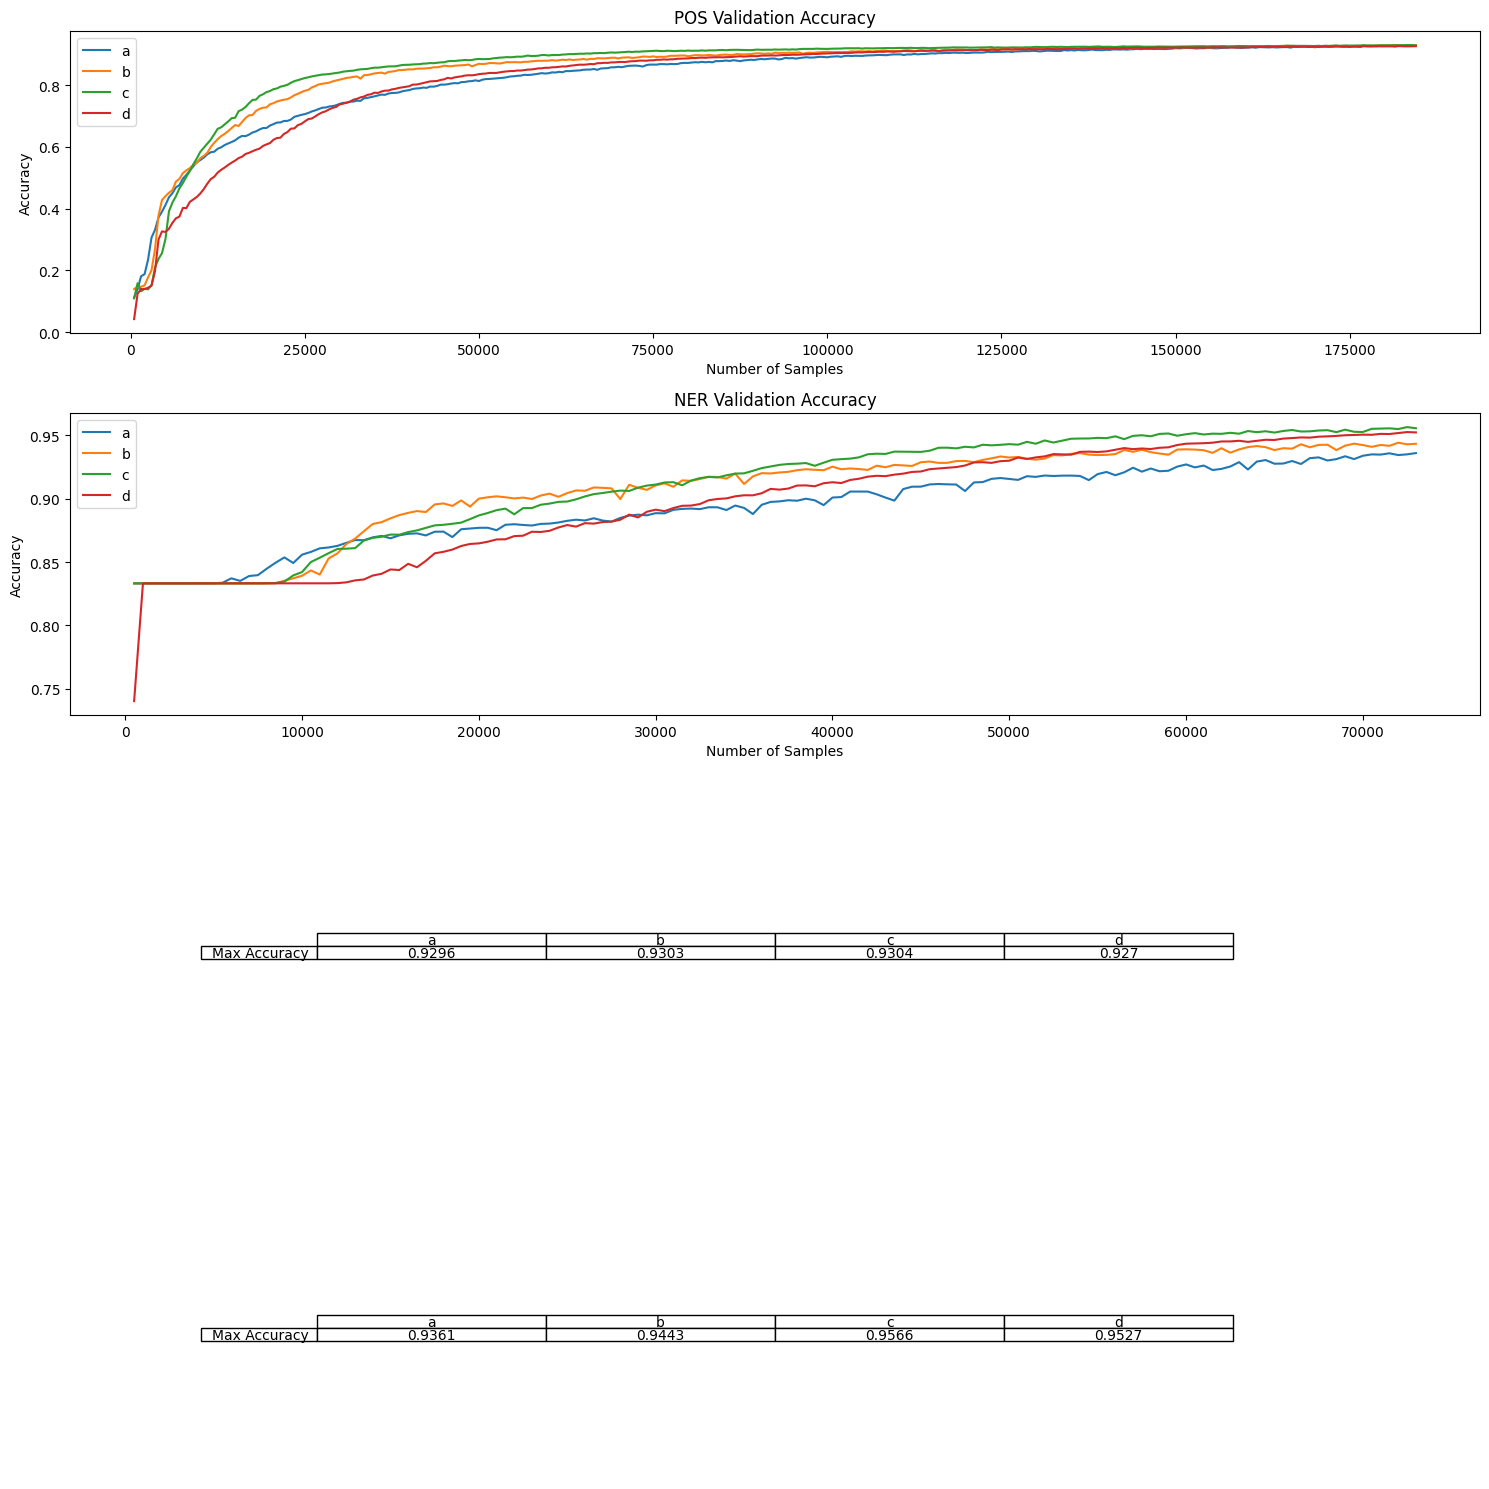

In [199]:
import matplotlib.pyplot as plt
import pandas as pd

samples_POS = list(range(500, 500*(len(dev_acc_POS['a'])+1), 500))
samples_NER = list(range(500, 500*(len(dev_acc_NER['a'])+1), 500))

# converting the dictionaries into pandas DataFrames
df_POS = pd.DataFrame(dev_acc_POS, index=samples_POS)
df_NER = pd.DataFrame(dev_acc_NER, index=samples_NER)

# creating subplots
fig, ax = plt.subplots(4, 1, figsize=(15, 15))  # Increase width, add 2 more subplots for tables

# POS plot
df_POS.plot(ax=ax[0])
ax[0].set_title('POS Validation Accuracy')
ax[0].set_xlabel('Number of Samples')
ax[0].set_ylabel('Accuracy')

# creating a table for POS
table_data_POS = df_POS.max().to_frame().T.round(4)  # Round to 4 decimal places
table_data_POS.index = ['Max Accuracy']
table_POS = ax[2].table(cellText=table_data_POS.values, colLabels=table_data_POS.columns, rowLabels=table_data_POS.index, cellLoc='center', loc='center')
table_POS.scale(0.65, 0.65)  # Further scale up table size slightly
ax[2].axis('tight')  # Hide axis for table
ax[2].axis('off')

# NER plot
df_NER.plot(ax=ax[1])
ax[1].set_title('NER Validation Accuracy')
ax[1].set_xlabel('Number of Samples')
ax[1].set_ylabel('Accuracy')

# creating a table for NER
table_data_NER = df_NER.max().to_frame().T.round(4)  # Round to 4 decimal places
table_data_NER.index = ['Max Accuracy']
table_NER = ax[3].table(cellText=table_data_NER.values, colLabels=table_data_NER.columns, rowLabels=table_data_NER.index, cellLoc='center', loc='center')
table_NER.scale(0.65, 0.65)  # Further scale up table size slightly
ax[3].axis('tight')  # Hide axis for table
ax[3].axis('off')

# adjusting the space between subplots
plt.subplots_adjust(hspace=0.5)

# showing the plots
plt.tight_layout()
plt.show()


In [36]:
import argparse
import logging

def get_runner(repr, train_file, model_filepath, delimiter):
    """
    Function to initialize the appropriate runner
    Args:
    repr (str): representation type, should be one of ['a', 'b', 'c', 'd']
    train_file (str): path to the training file
    model_filepath (str): path to the model file

    Returns:
    runner (Runner_A or Runner_B): initialized runner
    """
    if repr == 'a':
        return Runner_A(train_dataset_path=train_file, test_dataset_path=train_file, dev_dataset_path=train_file, base_dir=PREDS_3_A, delimiter=delimiter, batch_size=32, learning_rate=0.001, embedding_dim=10, lstm_hidden_dim=64, dropout=0)
    elif repr == 'b':
        return Runner_B(train_dataset_path=train_file, test_dataset_path=train_file, dev_dataset_path=train_file, base_dir=PREDS_3_A, delimiter=delimiter, batch_size=32, learning_rate=0.001, char_embedding_dim=10, lstm_hidden_dim=64, dropout=0)
    elif repr == 'c':
        return Runner_C(train_dataset_path=train_file, test_dataset_path=train_file, dev_dataset_path=train_file, base_dir=PREDS_3_A, delimiter=delimiter, batch_size=32, external_embedding=True)
    elif repr == 'd':
        return Runner_C(train_dataset_path=train_file, test_dataset_path=train_file, dev_dataset_path=train_file, base_dir=PREDS_3_A, delimiter=delimiter, batch_size=32, c_task=False)
    else:
        raise ValueError(f"Invalid repr {repr}. Should be one of ['a', 'b', 'c', 'd']")

def main():
    parser = argparse.ArgumentParser(description='BILSTM Training script')
    parser.add_argument('repr', type=str, help='Representation type. Should be one of [a,b,c,d]')
    parser.add_argument('trainFile', type=str, help='Path to the training file')
    parser.add_argument('modelFilepath', type=str, help='Path to the model file')

    args = parser.parse_args()

    # Check if all arguments were provided
    if not all([args.repr, args.trainFile, args.modelFilepath]):
        parser.error('All arguments repr, trainFile and modelFilepath must be provided')
    
    logging.basicConfig(level=logging.INFO)
    logger = logging.getLogger(__name__)
    logger.info('Starting BILSTM Training...')

    try:
        runner = get_runner(args.repr, args.trainFile, args.modelFilepath)
        if repr == 'd':
            runner.run(5, d, args.modelFilepath)  # Assuming there's a `run` method in your Runner classes
        else:
            runner.run(5, args.modelFilepath)  # Assuming there's a `run` method in your Runner classes
        logger.info('BILSTM Training completed successfully')
    except Exception as e:
        logger.error(f'An error occurred: {str(e)}')


In [38]:
import argparse
import logging

def get_runner(repr, test_file, modelFile):
    """
    Function to initialize the appropriate runner
    Args:
    repr (str): representation type, should be one of ['a', 'b', 'c', 'd']
    train_file (str): path to the training file
    model_filepath (str): path to the model file

    Returns:
    runner (Runner_A or Runner_B): initialized runner
    """
    if repr == 'a':
        runner = Runner_A(train_dataset_path=test_file, test_dataset_path=test_file, dev_dataset_path=test_file, base_dir=PREDS_3_A, delimiter=delimiter, batch_size=32, learning_rate=0.001, embedding_dim=10, lstm_hidden_dim=64, dropout=0)
    elif repr == 'b':
        runner = Runner_B(train_dataset_path=test_file, test_dataset_path=test_file, dev_dataset_path=test_file, base_dir=PREDS_3_A, delimiter=delimiter, batch_size=32, learning_rate=0.001, char_embedding_dim=10, lstm_hidden_dim=64, dropout=0)
    elif repr == 'c':
        runner = Runner_C(train_dataset_path=test_file, test_dataset_path=test_file, dev_dataset_path=test_file, base_dir=PREDS_3_A, delimiter=delimiter, batch_size=32, external_embedding=True)
    elif repr == 'd':
        runner = Runner_C(train_dataset_path=test_file, test_dataset_path=test_file, dev_dataset_path=test_file, base_dir=PREDS_3_A, delimiter=delimiter, batch_size=32, c_task=False)
    else:
        raise ValueError(f"Invalid repr {repr}. Should be one of ['a', 'b', 'c', 'd']")
        
    runner.load_test(args.test_file, args.modelFile)
    return runner


def main():
    parser = argparse.ArgumentParser(description='BILSTM Prediction script')
    parser.add_argument('repr', type=str, help='Representation type. Should be one of [a,b,c,d]')
    parser.add_argument('modelFile', type=str, help='Path to the model file')
    parser.add_argument('inputFile', type=str, help='Path to the input file')

    args = parser.parse_args()

    # Check if all arguments were provided
    if not all([args.repr, args.modelFile, args.inputFile]):
        parser.error('All arguments repr, modelFile and inputFile must be provided')
    
    logging.basicConfig(level=logging.INFO)
    logger = logging.getLogger(__name__)
    logger.info('Starting BILSTM Prediction...')

    try:
        runner = get_runner(args.repr, args.inputFile, args.modelFile)
        dataset = DATASETS[args.repr]
        runner.load_test(args.inputFile, args.modelFile, dataset)
        runner.predict(args.inputFile, args.modelFile)

        logger.info('BILSTM Prediction completed successfully')
    except Exception as e:
        logger.error(f'An error occurred: {str(e)}')